## 1. Import data and Libraries:

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re  
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from spatial_join_school import transform_to_geometry
import folium

In [2]:
query_school = '''
SELECT 
s.school_id,
s.name,
s.address,
s.school_hour,
s.grades, 
s.ward, 
s.area,
s.total_enrolment,
s.programs_list,
s.`desc`,
s.kindergarten_enrolment,
s.grade_1_enrolment,
s.grade_2_enrolment,
s.grade_3_enrolment,
s.grade_4_enrolment,
s.grade_5_enrolment,
s.grade_6_enrolment,
s.grade_7_enrolment,
s.grade_8_enrolment,
s.grade_9_enrolment,
s.grade_10_enrolment,
s.grade_11_enrolment,
s.grade_12_enrolment,
sr.school_rating,
sr.school_rank,
sr.school_group,
CASE 
        WHEN sl.school_id IS NOT NULL THEN True
        ELSE False
    END AS lottery_requirement,
sl.remarks AS lottery_programs
FROM schools s
LEFT JOIN school_ranking sr ON sr.school_id = s.school_id
LEFT JOIN school_lottery sl ON sl.school_id = s.school_id

'''
with sqlite3.connect('database.db') as conn:
    schools = pd.read_sql_query(query_school,conn)



## 2. How does my schools data look like?

In [3]:
schools.head(2)

school_id                       name  \
0          1  Children's Village School   
1          2  William Roper Hull School   

                                    address  school_hour grades ward area  \
0     1210 Russet Rd NE Calgary, AB T2E 5L5  8:30 - 2:30    K-6    9    2   
1  2266 Woodpark Ave SW Calgary, AB T2W 2Z8  8:45 - 3:15   1-12   13    6   

   total_enrolment programs_list  \
0               79                 
1               97                 

                                                desc  ...  grade_8_enrolment  \
0  Children's Village School is a unique setting ...  ...                  0   
1  William Roper Hull School is operated as a par...  ...                 12   

   grade_9_enrolment  grade_10_enrolment  grade_11_enrolment  \
0                  0                   0                   0   
1                 16                  14                  14   

   grade_12_enrolment  school_rating  school_rank  school_group  \
0                   0            NaN         None          None   
1                  10            NaN         None          None   

   lottery_requirement  lottery_programs  
0                    0              None  
1                    0              None  

[2 rows x 28 columns]

- **School Hours Formatting:**
  - The `school_hour` column contains string values representing the start and end times of the school day, separated by a hyphen. For analytical purposes, this string format could be split and transformed into a datetime format.

- **Enrollment Data by Grade:**
  - Each school includes 13 columns reflecting the number of enrollments for each grade. If a school does not offer a particular grade, the enrollment count for that grade is zero. This high incidence of zeros could potentially skew statistical analyses and affect the distribution of the data.

In [4]:
# Changing dtype 
schools['lottery_requirement'] = schools['lottery_requirement'].astype(bool)

In [5]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   school_id               250 non-null    int64  
 1   name                    250 non-null    object 
 2   address                 250 non-null    object 
 3   school_hour             250 non-null    object 
 4   grades                  250 non-null    object 
 5   ward                    250 non-null    object 
 6   area                    250 non-null    object 
 7   total_enrolment         250 non-null    int64  
 8   programs_list           250 non-null    object 
 9   desc                    250 non-null    object 
 10  kindergarten_enrolment  250 non-null    int64  
 11  grade_1_enrolment       250 non-null    int64  
 12  grade_2_enrolment       250 non-null    int64  
 13  grade_3_enrolment       250 non-null    int64  
 14  grade_4_enrolment       250 non-null    in

- **Total Number of Schools:** 
  - There are 250 schools listed under the CBE.
  
- **Data Integrity:** 
  - Columns 0 to 22 show no null values, as this information is sourced directly from the CBE's official website.
  https://cbe.ab.ca/schools/school-directory/Pages/default.aspx# 

- **School Rankings:** 
  - As seen from column #23 - #25, out of the 250 schools, only 110 have associated rankings from the Fraser Institute. This discrepancy is addressed in the Fraser Institute's FAQ, Question 1, explaining why certain schools lack rankings:
  https://www.compareschoolrankings.org/faq

- **School Group Representation:** 
  - Due to the partial matching of schools with Fraser Institute rankings, the 'school_group' data in column 25 may not fully represent all CBE schools.

- **Lottery Requirements:** 
  - The 'lottery_requirement' field does not contain null values. This is based on the assumption that the CBE reports only those public schools with a lottery requirement on their website as follows, and if a school is not reported as such, it does not require a lottery. 
  https://cbe.ab.ca/registration/registration/lottery/Pages/Schools-With-A-Program-In-Lottery.aspx

  - For simplicity, all non-CBE schools are labelled not requiring lottery.
  
- **Lottery Programs Specificity:** 
  - In the 'lottery_programs' column, only 11 schools have clearly indicated which specific program requires a lottery.
  

## 3. What is the distribution of enrolment numbers for each grade? How many schools are available for each grade?

In [6]:
schools.describe()

school_id  total_enrolment  kindergarten_enrolment  \
count    250.000000       250.000000              250.000000   
mean     404.392000       553.612000               35.832000   
std     1789.965347       390.178074               35.567174   
min        1.000000        25.000000                0.000000   
25%       64.250000       305.750000                0.000000   
50%      129.500000       482.500000               30.500000   
75%      193.750000       653.000000               59.750000   
max    15486.000000      2281.000000              143.000000   

       grade_1_enrolment  grade_2_enrolment  grade_3_enrolment  \
count         250.000000         250.000000          250.00000   
mean           43.528000          43.392000           40.45600   
std            41.504551          41.240775           38.59438   
min             0.000000           0.000000            0.00000   
25%             0.000000           0.000000            0.00000   
50%            37.000000          39.000000           35.50000   
75%            75.750000          75.000000           69.00000   
max           149.000000         150.000000          153.00000   

       grade_4_enrolment  grade_5_enrolment  grade_6_enrolment  \
count         250.000000         250.000000         250.000000   
mean           42.468000          40.580000          41.880000   
std            39.513113          40.096315          51.984412   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%            42.000000          35.000000          28.500000   
75%            70.750000          64.000000          62.750000   
max           152.000000         179.000000         282.000000   

       grade_7_enrolment  grade_8_enrolment  grade_9_enrolment  \
count         250.000000         250.000000         250.000000   
mean           41.148000          41.172000          41.128000   
std            73.538546          73.460904          73.534788   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%            59.000000          59.750000          59.750000   
max           275.000000         278.000000         275.000000   

       grade_10_enrolment  grade_11_enrolment  grade_12_enrolment  \
count          250.000000           250.00000          250.000000   
mean            45.748000            44.31200           51.968000   
std            155.558859           148.84705          163.300125   
min              0.000000             0.00000            0.000000   
25%              0.000000             0.00000            0.000000   
50%              0.000000             0.00000            0.000000   
75%              0.000000             0.00000            0.000000   
max            760.000000           792.00000          918.000000   

       school_rating  
count     110.000000  
mean        6.046364  
std         1.901167  
min         0.900000  
25%         5.100000  
50%         6.100000  
75%         7.700000  
max        10.000000

### 3.1 Analysis of total enrolment

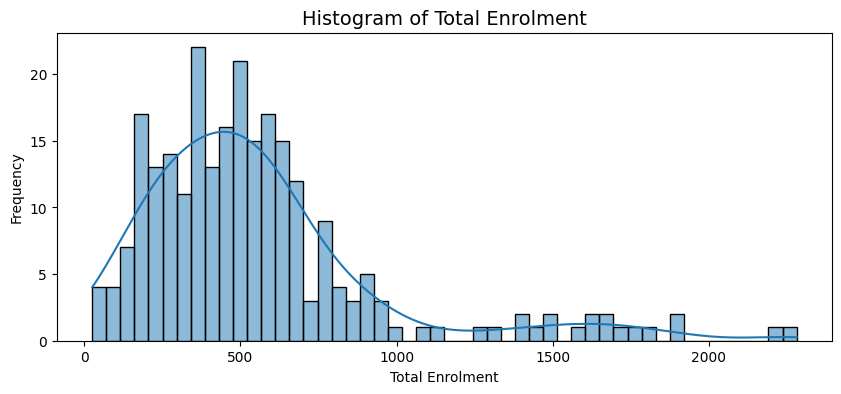

In [7]:
# Create the histogram
plt.figure(figsize=(10, 4))  # Sets the figure size for better readability
sns.histplot(schools['total_enrolment'], kde=True, bins=50)

# Add title and labels
plt.title('Histogram of Total Enrolment', size=14)
plt.xlabel('Total Enrolment', size=10)
plt.ylabel('Frequency', size=10)

# Show the plot
plt.show()

- The average school size is just over 550 students, but there's a wide range in enrollment numbers, from very small schools (minimum of 25 students) to quite large ones (maximum of 2281 students).
- Half of the schools have fewer than 500 students, indicating that smaller schools are common.
- There's a significant spread in the size of schools, as shown by the large standard deviation, meaning that student populations are not consistent across schools.

### 3.2 Analysis of number of enrolment by grade and division

In [8]:
# Define the grade order and titles
grades_groups = {
    'Early Childhood': [
        'kindergarten_enrolment'
    ],
    'Elementary': [
        'grade_1_enrolment', 'grade_2_enrolment',
        'grade_3_enrolment', 'grade_4_enrolment', 'grade_5_enrolment',
        'grade_6_enrolment'
    ],
    'Junior High': [
        'grade_7_enrolment', 'grade_8_enrolment', 'grade_9_enrolment'
    ],
    'Senior High': [
        'grade_10_enrolment', 'grade_11_enrolment', 'grade_12_enrolment'
    ]
}

# Define classification functions
def is_ecs(row):
    return any(row[grade] > 0 for grade in grades_groups['Early Childhood'])

def is_elementary(row):
    return any(row[grade] > 0 for grade in grades_groups['Elementary'])

def is_junior_high(row):
    return any(row[grade] > 0 for grade in grades_groups['Junior High'])

def is_senior_high(row):
    return any(row[grade] > 0 for grade in grades_groups['Senior High'])

# Apply classifications across the rows of the DataFrame
schools['early_childhood'] = schools.apply(is_ecs, axis=1)
schools['elementary'] = schools.apply(is_elementary, axis=1)
schools['junior_high'] = schools.apply(is_junior_high, axis=1)
schools['senior_high'] = schools.apply(is_senior_high, axis=1)

       count       mean        std  min   25%   50%   75%    max
Grade                                                           
K      159.0  56.339623  28.825496  1.0  33.5  52.0  77.5  143.0
       count       mean        std  min    25%   50%    75%    max
Grade                                                             
1      164.0  66.353659  33.281241  1.0  37.75  65.5  88.25  149.0
2      164.0  66.146341  32.921219  1.0  40.75  64.5  92.00  150.0
3      164.0  61.670732  30.968638  2.0  36.00  60.0  83.25  153.0
4      166.0  63.957831  31.198553  1.0  42.25  59.5  81.00  152.0
5      170.0  59.676471  34.962973  1.0  35.00  53.5  82.75  179.0
6      163.0  64.233129  52.047885  1.0  29.50  53.0  86.00  282.0
       count        mean        std  min    25%    50%    75%    max
Grade                                                               
7       74.0  139.013514  68.228964  1.0  98.25  151.5  180.0  275.0
8       74.0  139.094595  67.824546  4.0  94.50  148.5  190.5 

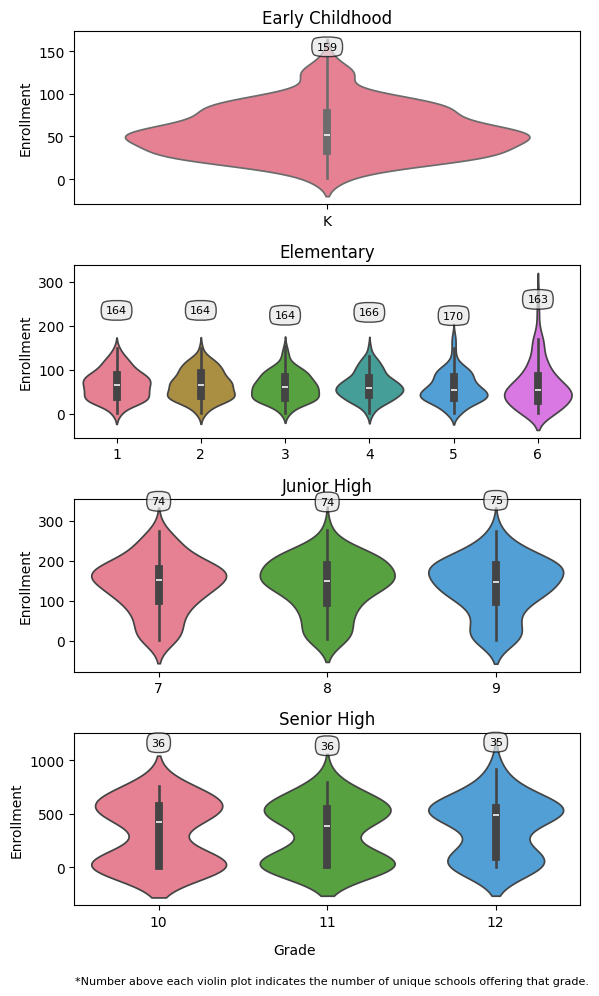

In [9]:


# Create a figure to hold the subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 10))  # Adjust the figsize as needed

# Function to extract the grade number from the column name
def get_grade_number(column):
    if column.startswith('kindergarten'):
        return 'K'
    else:
        return column.split('_')[1]

# Loop through each group of grades and create the violin plots
for i, (title, grades) in enumerate(grades_groups.items()):
    # Concatenate data only for the grades in the current group
    group_data = schools[grades + ['school_id']].melt(
        id_vars='school_id', 
        var_name='Grade', 
        value_name='Enrollment'
    )
    
    # Filter out rows with zero enrollment
    group_data = group_data[group_data['Enrollment'] > 0]

    # Shorten the x-axis labels to only show the grade number
    group_data['Grade'] = group_data['Grade'].apply(get_grade_number)
    
    # Calculate the number of unique schools for each grade
    unique_schools = group_data.groupby('Grade')['school_id'].nunique()
    
    # Create a violin plot for the current group with a specified color palette
    sns.violinplot(
        x='Grade',
        y='Enrollment',
        data=group_data,
        ax=axes[i],
        hue='Grade',
        palette='husl'
    )
    
    # Annotate the number of unique schools on top of each violin
    for j, grade in enumerate(unique_schools.index):
        percentile = np.percentile(group_data[group_data['Grade'] == grade]['Enrollment'], 90) #avoid the impact to annotation placement by extreme values
        axes[i].annotate(
            str(unique_schools[grade]),
            xy=(j, percentile),
            xytext=(0, 35),  # 35 points vertical offset for clarity
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=8,
            color='black',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9", alpha=0.7)
        )
    
    # Set the title and labels for each subplot
    axes[i].set_title(title)
    axes[i].set_xlabel('')  # The common x-axis label will be set after the loop
    axes[i].set_ylabel('Enrollment')
    
    print(group_data.groupby('Grade')['Enrollment'].describe())

# Set a common x-axis label "Grade" for all subplots
fig.text(0.5, 0.04, 'Grade', ha='center')

# Add a note about the annotations to the figure
fig.text(0.99, 0.01, '*Number above each violin plot indicates the number of unique schools offering that grade.',
         horizontalalignment='right', fontsize=8)

# Automatically adjust the subplot params for better layout
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make space for the common x-axis label

# Show the combined plot
plt.show()

- **Increased Average Enrollment in Higher Grades:** 
  - The mean enrollment significantly jumps for grades 10-12 (`317.69`, `307.72`, `371.2`) compared to lower grades like kindergarten (`56.34`) and grades 1-3 (around `66`), which might be due to fewer schools offering higher grades, thus consolidating students.
  
- **High Variability in Senior High School Enrollment:** 
  - Grades 10-12 exhibit much larger standard deviations (`288.60`, `272.48`, `270.76`) compared to those of the lower grades, highlighting the disparate class sizes at this educational level.

- **Range Extremes in Junior and Senior High:** 
  - The enrollment range for grades 7-12 shows higher maximums (`275` to `918`) than in earlier grades (`143` to `179`), indicating the presence of much larger classes or schools at the higher grade levels.

- **Median Skew Toward Larger Classes in Higher Grades:** 
  - Medians for grades 7-12 (`151.5`, `148.5`, `146` for grades 7-9 and `421`, `381.5`, `487` for grades 10-12) are consistently higher than the means, suggesting a rightward skew towards larger class sizes.


## 4. What is the distribution of school hour?

### 4.1 Data cleaning and transformation

In [10]:


# Regular expression pattern for checking if a time is in the format XX:XX
time_pattern = re.compile(r'^\d{1,2}:\d{2}$')

def validate_and_convert_time(time_str, is_pm=False):
    # Validate the time format
    if not time_pattern.match(time_str):
        return None
    
    # Parse the time
    try:
        time_obj = datetime.strptime(time_str, '%I:%M')
        if is_pm:  # If it's the end time (PM), we add 12 hours to convert to 24-hour format
            time_obj += pd.Timedelta(hours=12)
        return time_obj.strftime('%H:%M')
    except ValueError:
        return None

def process_school_hour(school_hour):
    # Split the string into start and end times
    try:
        start_hour, end_hour = school_hour.split(' - ')
        # Remove any whitespace and lowercase am/pm indicators
        start_hour = start_hour.lower().replace('am', '').replace('pm', '').strip()
        end_hour = end_hour.lower().replace('am', '').replace('pm', '').strip()

        # Validate and convert times
        start_hour_24 = validate_and_convert_time(start_hour)
        end_hour_24 = validate_and_convert_time(end_hour, is_pm=True)
        
        return start_hour_24, end_hour_24
    except ValueError:
        # Return None for both if there's an issue with splitting or conversion
        return None, None


# Apply the function to the dataframe

schools[['start_hour', 'end_hour']] = schools.apply(
    lambda row: pd.Series(process_school_hour(row['school_hour'])),
    axis=1
)


In [11]:
schools[['school_hour', 'start_hour', 'end_hour']].isnull().value_counts()

school_hour  start_hour  end_hour
False        False       False       245
                         True          3
             True        True          2
Name: count, dtype: int64

In [12]:
schools[['start_hour', 'end_hour']].value_counts()

start_hour  end_hour
08:00       14:30       24
09:10       15:50       15
08:00       14:40       14
08:30       15:10       11
08:00       14:35        7
                        ..
08:25       15:13        1
            15:10        1
            15:08        1
            14:55        1
09:15       16:04        1
Name: count, Length: 128, dtype: int64

In [13]:
# Convert start_hour and end_hour to datetime to extract the hour
schools['start_hour'] = pd.to_datetime(schools['start_hour'], format='%H:%M').dt.hour
schools['end_hour'] = pd.to_datetime(schools['end_hour'], format='%H:%M').dt.hour

In [14]:
# Function to determine the classification of a school
def classify_school(row):
    classes = []
    if row['early_childhood']:
        classes.append('ECS')
    if row['elementary']:
        classes.append('Elem')
    if row['junior_high']:
        classes.append('Jr High')
    if row['senior_high']:
        classes.append('Sr High')
    return ', '.join(classes)

# Apply the function to each row of the DataFrame
schools['classification'] = schools.apply(classify_school, axis=1)

### 4.2 Analysis of school start and end hours

In [15]:
schools[['start_hour', 'end_hour']].value_counts()

start_hour  end_hour
8.0         15.0        100
            14.0         80
9.0         15.0         52
7.0         14.0         11
            22.0          1
9.0         16.0          1
Name: count, dtype: int64

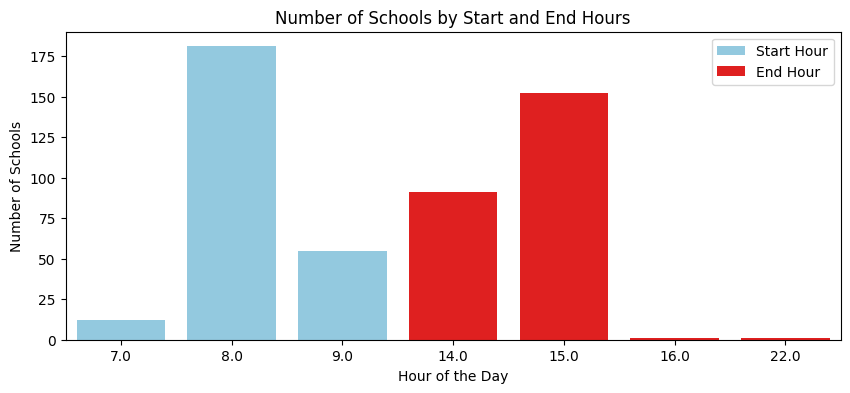

In [16]:
# Create a figure with a specific size
plt.figure(figsize=(10, 4))

# Create a bar plot for start hours
sns.countplot(x='start_hour', data=schools, color="skyblue", label='Start Hour')

# Create a bar plot for end hours
sns.countplot(x='end_hour', data=schools, color="red", label='End Hour')

# Add a legend
plt.legend()

# Set the labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Schools')
plt.title('Number of Schools by Start and End Hours')

# Display the plot
plt.show()

- **Peak Hours for End Time at 15:00:**
  - The highest count of occurrences is for a start hour of `8.0` and an end hour of `15.0`, indicating a conventional school or workday schedule.

- **Significant Drop Before the Peak End Hour:**
  - There is a noticeable decrease in count for an end hour of `14.0` with the same start hour (`8.0`), suggesting fewer institutions or activities ending an hour earlier.

- **Mid-Morning Starts Ending Mid-Afternoon:**
  - For a start hour of `9.0`, the count drops to `52` for an end hour of `15.0`, which might reflect a later start for certain programs or shifts.


early_childhood
start_hour  end_hour
8.0         15.0        0.405063
            14.0        0.379747
9.0         15.0        0.177215
7.0         14.0        0.037975
Name: proportion, dtype: float64
elementary
start_hour  end_hour
8.0         15.0        0.395238
            14.0        0.361905
9.0         15.0        0.190476
7.0         14.0        0.047619
9.0         16.0        0.004762
Name: proportion, dtype: float64
junior_high
start_hour  end_hour
8.0         14.0        0.369863
            15.0        0.301370
9.0         15.0        0.260274
7.0         14.0        0.054795
9.0         16.0        0.013699
Name: proportion, dtype: float64
senior_high
start_hour  end_hour
8.0         15.0        0.575758
9.0         15.0        0.333333
8.0         14.0        0.060606
7.0         22.0        0.030303
Name: proportion, dtype: float64


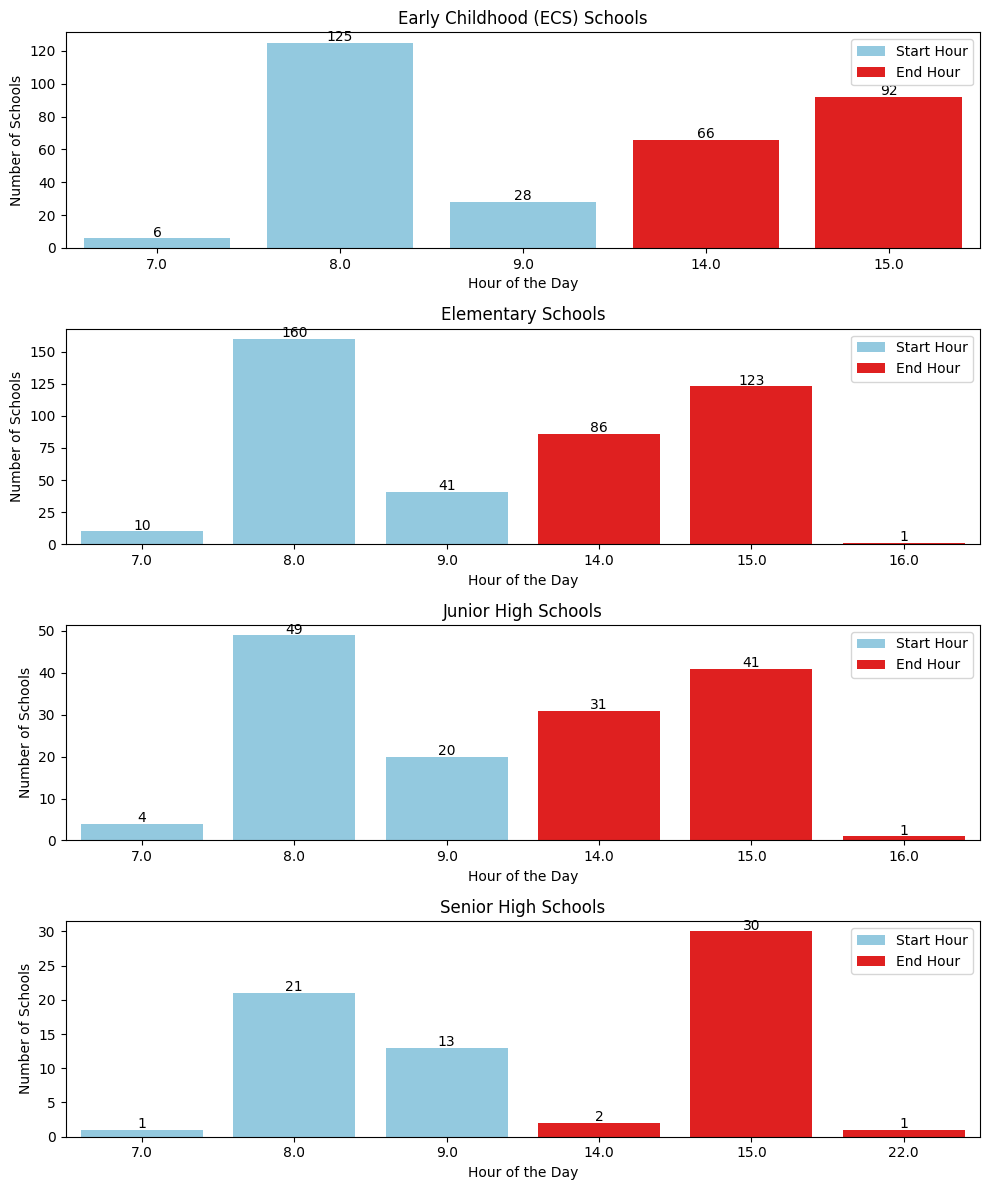

In [17]:

# Create a figure with specified size and subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# Define a color palette for start and end hours
colors = ["skyblue", "red"]

# Define school levels
school_levels = ['early_childhood', 'elementary', 'junior_high', 'senior_high']
titles = ['Early Childhood (ECS) Schools', 'Elementary Schools', 'Junior High Schools', 'Senior High Schools']

# Loop over school levels to create each subplot
for i, level in enumerate(school_levels):
    print(level)
    print(schools[schools[level]][['start_hour', 'end_hour']].value_counts(normalize=True))
    # Plot the start_hour and end_hour countplots
    sns.countplot(ax=axes[i], x='start_hour', data=schools[schools[level]], color=colors[0], label='Start Hour')
    sns.countplot(ax=axes[i], x='end_hour', data=schools[schools[level]], color=colors[1], label='End Hour')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Number of Schools')
    axes[i].legend()
    
    # Annotate the bars
    for bar in axes[i].patches:
        # Get the height and position of each bar
        height = bar.get_height()
        x_position = bar.get_x() + bar.get_width() / 2
        
        # Create the annotation with the height (number of schools)
        axes[i].annotate(f'{int(height)}', 
                         xy=(x_position, height), 
                         xytext=(0, 4),  # 4 points vertical offset
                         textcoords='offset points',
                         ha='center', va='center')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### School Schedules: Comparative Percentage Insights

- **Early Start and End Times**:
  - Early Childhood has 38% of schools ending at 2 pm, while Elementary has a similar proportion at 36%.
  - Junior High sees a higher preference for ending at 2 pm with nearly 37%.
  - Senior High diverges, with most schools (58%) maintaining a standard 8 am to 3 pm schedule.

- **Standard Full-Day Schedule**:
  - The 8 am to 3 pm schedule is most common across all stages, but it's most prevalent in Senior High (58%), followed by Early Childhood (41%), Elementary (40%), and Junior High (30%).

- **Late Start Flexibility**:
  - A significant proportion of Early Childhood (18%) and Elementary (19%) schools start at 9 am and end at 3 pm.
  - This trend continues in Junior High with 26% adopting a 9 am start.

- **Extended Hours and Outliers**:
  - Junior High has a small percentage (1.4%) that extends the day to 4 pm.
  - Senior High features a unique outlier with one school having an extended schedule from 7 am to 10 pm (3%).

### 4.3 Analysis by school duration

In [18]:
schools['school_duration'] = schools['end_hour'] - schools['start_hour']

In [19]:
schools['school_duration'].value_counts()

school_duration
6.0     132
7.0     112
15.0      1
Name: count, dtype: int64

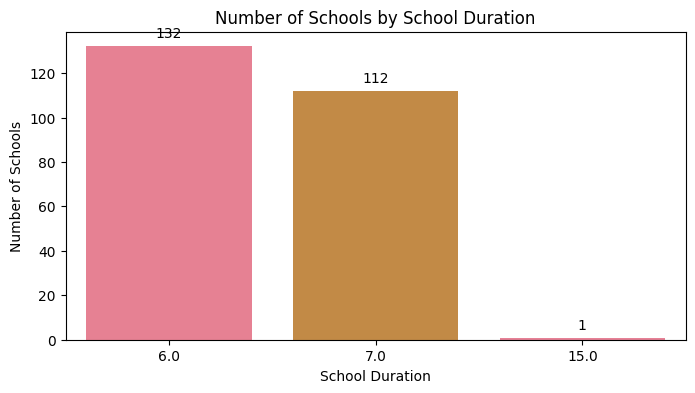

In [20]:
# Create a figure with a specific size
plt.figure(figsize=(8, 4))

# Create a count plot/bar plot for school durations
# Seaborn will automatically use different colors for each bar
ax = sns.countplot(x='school_duration', data=schools, hue ='school_duration',legend = False, palette='husl')

# Set the labels and title
plt.xlabel('School Duration')
plt.ylabel('Number of Schools')
plt.title('Number of Schools by School Duration')

# Add a label on top of each bar to show its number of schools
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # The label text
                 (p.get_x() + p.get_width() / 2., p.get_height()),  # The position
                 ha='center', va='center',  # Center alignment
                 xytext=(0, 9),  # Text offset
                 textcoords='offset points')  # Offset (in points) from the original position

# Display the plot
plt.show()

- **Predominant 6-Hour School Day:**
  - The most common school duration is `6.0` hours, with a count of `132`, suggesting this length aligns with the standard expectations for a school day.

- **Substantial 7-Hour Days:**
  - A significant number of schools have a `7.0`-hour day, represented by `112` counts, indicating a preference for a slightly extended school day.

In [21]:
schools.columns

Index(['school_id', 'name', 'address', 'school_hour', 'grades', 'ward', 'area',
       'total_enrolment', 'programs_list', 'desc', 'kindergarten_enrolment',
       'grade_1_enrolment', 'grade_2_enrolment', 'grade_3_enrolment',
       'grade_4_enrolment', 'grade_5_enrolment', 'grade_6_enrolment',
       'grade_7_enrolment', 'grade_8_enrolment', 'grade_9_enrolment',
       'grade_10_enrolment', 'grade_11_enrolment', 'grade_12_enrolment',
       'school_rating', 'school_rank', 'school_group', 'lottery_requirement',
       'lottery_programs', 'early_childhood', 'elementary', 'junior_high',
       'senior_high', 'start_hour', 'end_hour', 'classification',
       'school_duration'],
      dtype='object')

early_childhood
school_duration
6.0    88
7.0    70
Name: count, dtype: int64
elementary
school_duration
6.0    116
7.0     94
Name: count, dtype: int64
junior_high
school_duration
6.0    46
7.0    27
Name: count, dtype: int64


senior_high
school_duration
7.0     19
6.0     13
15.0     1
Name: count, dtype: int64


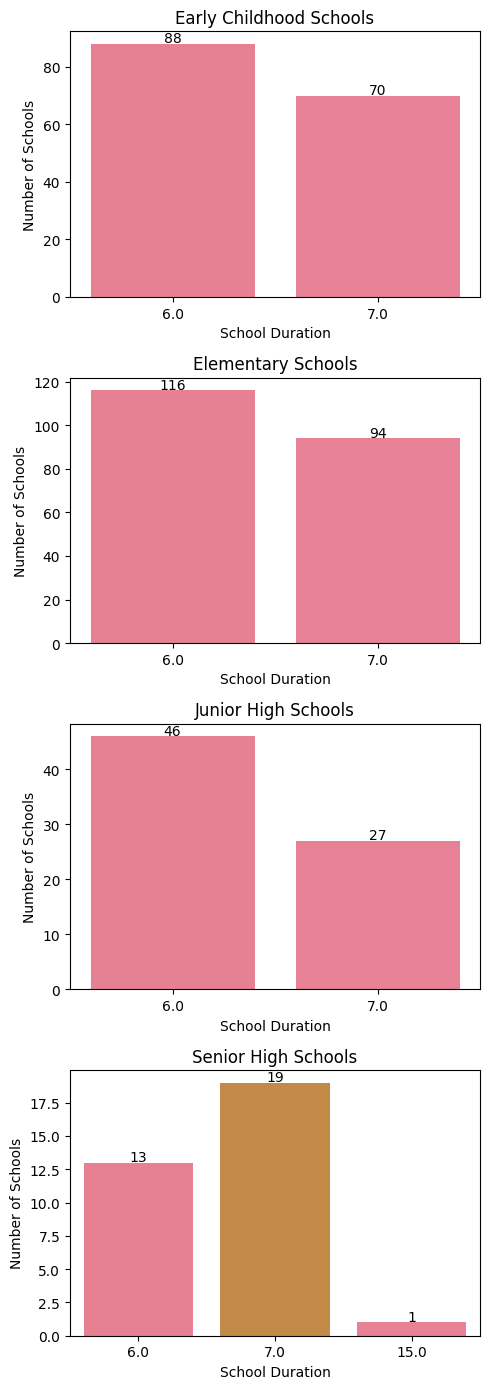

In [22]:

# Create a figure with specified size and subplots
fig, axes = plt.subplots(4, 1, figsize=(5, 14))  # 4 rows, 1 column

# Define the palette for school duration
palette = 'husl'

# Define a list for the classification columns
classifications = ['early_childhood', 'elementary', 'junior_high', 'senior_high']

# Loop through the classifications and create a subplot for each
for i, classification in enumerate(classifications):
    
    
    # Filter the DataFrame based on the classification
    filtered_data = schools[schools[classification]]
    
    print(classification)
    print(filtered_data['school_duration'].value_counts())
    # Create the count plot
    ax = sns.countplot(ax=axes[i], x='school_duration', data=filtered_data, hue='school_duration', palette=palette, dodge=False, legend=False)
    # Set the title, labels and remove the legend
    axes[i].set_title(f'{classification.replace("_", " ").title()} Schools')
    axes[i].set_xlabel('School Duration')
    axes[i].set_ylabel('Number of Schools')
    
    # Annotate the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 4),
                    textcoords='offset points')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### Early Childhood
- **6-Hour vs. 7-Hour Duration:**
  - `6.0`-hour school days are more common with `88` counts, compared to `70` counts for `7.0`-hour days, indicating a slight preference for shorter school days at this level.

### Elementary
- **Close Preference:**
  - The preference for `6.0`-hour days (`116` counts) over `7.0`-hour days (`94` counts) is noticeable, though the gap is not substantial, suggesting a fairly balanced distribution between the two durations.

### Junior High
- **6-Hour Duration More Frequent:**
  - `6.0`-hour school days are preferred with `46` counts, while `7.0`-hour days are less common with `27` counts, reflecting a clearer preference for shorter school days in junior high.

### Senior High
- **7-Hour Duration More Common:**
  - `7.0`-hour school days occur more frequently with `19` counts, overtaking the `6.0`-hour days which have `13` counts, indicating a trend towards longer school days as students mature.
- **Notable Exception:**
  - An exceptional `15.0`-hour school day is recorded once, standing out as a significant deviation from typical school durations.

In [23]:
schools[schools['school_duration'] == 15]

school_id                       name  \
164        170  Chinook Learning Services   

                                   address       school_hour grades ward area  \
164  2336 53 Avenue SW Calgary, AB T3E 1L2  7:00am - 10:00pm   7-12    8    5   

     total_enrolment programs_list  \
164              921                 

                                                  desc  ...  \
164  Chinook Learning Services is the Calgary Board...  ...   

     lottery_requirement  lottery_programs  early_childhood  elementary  \
164                False              None            False       False   

     junior_high  senior_high  start_hour  end_hour  classification  \
164        False         True         7.0      22.0         Sr High   

     school_duration  
164             15.0  

[1 rows x 36 columns]

The 15 hour exception case belongs to Chinook Learning Services. 

## 5. How good are CBE schools? How many of them requrie lottery for admission?

Looking at the 110 (out of 250) schools having a ranking by Fraser Institute...

In [24]:
schools_rating = schools[~schools['school_rating'].isnull()].copy()

In [25]:
schools_rating.groupby('school_group')['school_rating'].describe()

count      mean       std  min    25%  50%    75%   max
school_group                                                         
elementary     92.0  5.944565  1.945599  0.9  4.800  6.1  7.625  10.0
secondary      18.0  6.566667  1.602938  3.6  5.375  6.5  7.950   8.8

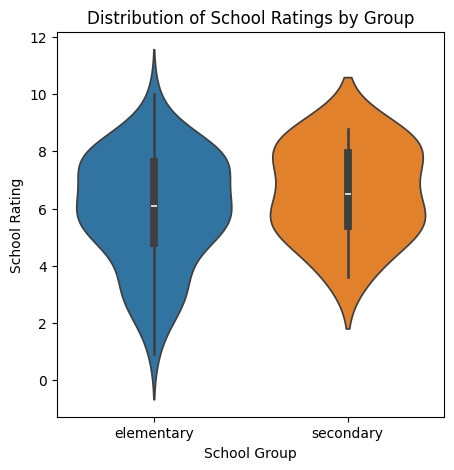

In [26]:
# Creating the violin plot
plt.figure(figsize=(5, 5))  # adjust the size of the figure as needed
violin_plot = sns.violinplot(x="school_group", y="school_rating", data=schools_rating, hue = "school_group")

# Customizing the plot
violin_plot.set_title('Distribution of School Ratings by Group')
violin_plot.set_xlabel('School Group')
violin_plot.set_ylabel('School Rating')

# Show the plot
plt.show()

### Overview
In an examination of 110 rated schools within the CBE system, we have a distribution of 92 elementary schools and 18 secondary schools. The ratings provide a quantitative measure of each school's performance on a scale from 0 (very bad) to 10 (excellent).

### Elementary Schools
There is a wide range of performances among elementary schools, with some performing poorly and others excelling. The high standard deviation relative to the rating scale underscores the importance of school selection within this category.

### Secondary Schools
Secondary schools show less variability in their ratings compared to elementary schools, with a tighter range of performance. The highest-rated CBE secondary school is 8.8, suggesting that the top-performing schools in the city might be outside the CBE system. The smaller sample size of secondary schools should be taken into account, as it may affect the reliability of the standard deviation as a measure of variability.

### Additional Insights
- **Comparative Performance**: The median ratings for both elementary and secondary schools are above the midpoint of the rating scale, which suggests that the typical school in both categories is performing in the upper half of the rating scale.
- **Top Performers**: The fact that the highest-rated elementary school is at the maximum of 10 indicates that there are exceptional schools within the CBE system. In contrast, the absence of secondary schools at the very top of the scale invites questions about the availability and performance of non-CBE high schools.
- **Potential Bias**: Given that secondary schools are fewer in number, it's possible that their ratings could be more susceptible to outliers or specific circumstances that wouldn't apply as much to the elementary schools.


Now let's include the `lottery_requirement` into the analysis:

In [27]:
schools_rating.groupby(['school_group', 'lottery_requirement'])['school_rating'].describe()

count      mean       std  min   25%  50%  \
school_group lottery_requirement                                              
elementary   False                 77.0  5.807792  1.950288  0.9  4.80  5.9   
             True                  15.0  6.646667  1.823602  2.7  5.45  7.4   
secondary    False                 17.0  6.623529  1.633451  3.6  5.30  6.8   
             True                   1.0  5.600000       NaN  5.6  5.60  5.6   

                                   75%   max  
school_group lottery_requirement              
elementary   False                7.40  10.0  
             True                 7.85   9.0  
secondary    False                8.00   8.8  
             True                 5.60   5.6

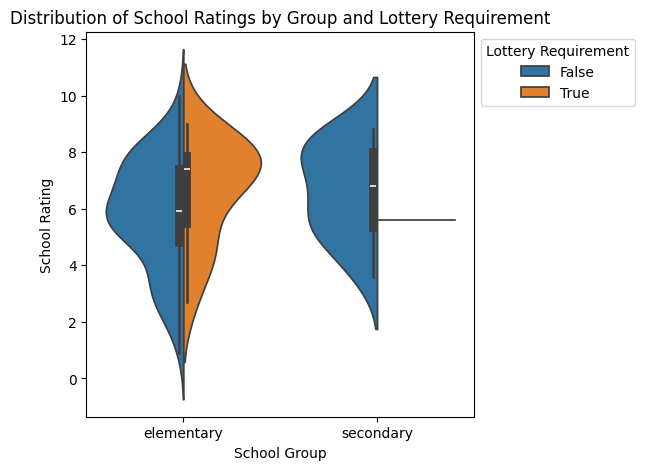

In [28]:
# Creating the half-violin plot
plt.figure(figsize=(5, 5))  # You can adjust the size of the figure as needed
violin_plot = sns.violinplot(x="school_group", y="school_rating", hue="lottery_requirement",
                             data=schools_rating, split=True)

# Customizing the plot
violin_plot.set_title('Distribution of School Ratings by Group and Lottery Requirement')
violin_plot.set_xlabel('School Group')
violin_plot.set_ylabel('School Rating')

# Optional: If you want to place the legend outside the plot
plt.legend(title='Lottery Requirement', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [29]:
# Increase the maximum width for displaying string columns
pd.set_option('display.max_colwidth', None)

filter = (schools_rating['school_group'] == 'elementary') & (schools_rating['lottery_requirement'] == True)
schools_rating[filter][['grades','programs_list','school_rating']]


grades                               programs_list  school_rating
8      K-6                                  Montessori            7.9
13     K-6                                     Regular            6.5
16     K-9           Traditional Learning Centre (TLC)            8.5
29     K-6                                     Regular            4.2
31     K-6                Regular, Regular, Montessori            7.6
46     K-6  Regular, Traditional Learning Centre (TLC)            2.7
51     K-6       Regular, Chinese (Mandarin) Bilingual            7.8
78     K-6                                  Montessori            7.4
95     K-6  Regular, Traditional Learning Centre (TLC)            4.7
108    K-6                                     Regular            7.0
120    K-9                                     Science            7.8
121    K-9                            Regular, Regular            6.2
129    K-9                                     Science            9.0
181    K-9                            Regular, Regular            4.5
237    K-9                                     Regular            7.9

In [30]:

# Reset the maximum width for displaying string columns to the default setting
pd.reset_option('display.max_colwidth')

- Among the 92 rated elementary schools, 15 requires lottery for admission, meaning that they were oversubscribed in the last school year. Among the 18 secondary school, the situation is better, only 1 requires lottery. 

- Elementary schools with a lottery requirement generally have higher ratings than those without, with an average rating about 0.83 points higher. The median rating of lottery schools is notably higher (7.4 vs. 5.9), suggesting that the top half of lottery schools perform better than the non-lottery counterparts. The range is also narrower, and the interquartile range is shifted towards higher ratings. This could imply that lottery-based schools are perceived as more desirable or that the lottery system correlates with higher school performance.

- For secondary schools, drawing conclusions is challenging due to the sample size. There is only one secondary school with a lottery requirement in the dataset, which has a rating of 5.6. This rating is below the median rating of non-lottery secondary schools (6.8). 


- As expected, the requirement of a lottery is associated with better performance, which is especially the evident for elementary schools.

## 6. Does special programs matter?

`programs_list` is now in form of a list. Before we analyse, we need to transform it into multiple boolean columns for each program utilizing the `MultiLabelBinarizer` from sci-kit learn.

In [31]:
schools['programs_list'].value_counts().head(10)

programs_list
Regular                                                   135
Regular, Regular                                           12
                                                           10
Regular, Advanced Placement (AP)                           10
Traditional Learning Centre (TLC)                           9
Spanish Bilingual                                           7
Early French Immersion                                      7
Regular, Early French Immersion                             7
Regular, Traditional Learning Centre (TLC)                  5
Regular, Early French Immersion, Late French Immersion      5
Name: count, dtype: int64

In [32]:

from sklearn.preprocessing import MultiLabelBinarizer

# Split the strings into lists of programs, stripping whitespace
schools['programs_list'] = schools['programs_list'].str.split(',').apply(lambda x: [i.strip() for i in x])

# Instantiate the MultiLabelBinarizer which is designed to handle a list of labels for multi-label encoding
mlb = MultiLabelBinarizer()

# Fit and transform the 'programs_list' column which contains lists of programs
encoded_programs = mlb.fit_transform(schools['programs_list'])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(
    encoded_programs,
    columns=mlb.classes_,
    index=schools.index
)

# Join the encoded DataFrame back with the original DataFrame
schools = schools.join(encoded_df)


In [33]:
schools.iloc[:, [*range(2), *range(-22, 0)]].head(3)

school_id                                           name  \
0          1                      Children's Village School   
1          2                      William Roper Hull School   
2          3  Wood's Homes - William Taylor Learning Centre   

   Advanced Placement (AP)  All Boys  All Girls  Alternative High School  \
0                        0         0          0                        0   
1                        0         0          0                        0   
2                        0         0          0                        0   

   Arts-Centred  Chinese (Mandarin) Bilingual  Early French Immersion  \
0             0                             0                       0   
1             0                             0                       0   
2             0                             0                       0   

   German Bilingual  ...  International Baccalaureate (IB)  \
0                 0  ...                                 0   
1                 0  ...                                 0   
2                 0  ...                                 0   

   Late French Immersion  Montessori  Online Learning  Outreach  \
0                      0           0                0         0   
1                      0           0                0         0   
2                      0           0                0         0   

   Pregnant & Parenting Teens  Regular  Science  Spanish Bilingual  \
0                           0        0        0                  0   
1                           0        0        0                  0   
2                           0        0        0                  0   

   Traditional Learning Centre (TLC)  
0                                  0  
1                                  0  
2                                  0  

[3 rows x 24 columns]

In [34]:
schools.columns

Index(['school_id', 'name', 'address', 'school_hour', 'grades', 'ward', 'area',
       'total_enrolment', 'programs_list', 'desc', 'kindergarten_enrolment',
       'grade_1_enrolment', 'grade_2_enrolment', 'grade_3_enrolment',
       'grade_4_enrolment', 'grade_5_enrolment', 'grade_6_enrolment',
       'grade_7_enrolment', 'grade_8_enrolment', 'grade_9_enrolment',
       'grade_10_enrolment', 'grade_11_enrolment', 'grade_12_enrolment',
       'school_rating', 'school_rank', 'school_group', 'lottery_requirement',
       'lottery_programs', 'early_childhood', 'elementary', 'junior_high',
       'senior_high', 'start_hour', 'end_hour', 'classification',
       'school_duration', '', 'Advanced Placement (AP)', 'All Boys',
       'All Girls', 'Alternative High School', 'Arts-Centred',
       'Chinese (Mandarin) Bilingual', 'Early French Immersion',
       'German Bilingual', 'Home Education', 'Indigenous Focus',
       'International Baccalaureate (Career)',
       'International Baccalaure

Now the encoded dataframe has extra 22 columns, each one represents the availability of a program that the school offers. 

In [35]:
#to avoid typing out the column names, let's store them in a list

program_columns = [
    'Advanced Placement (AP)', 'All Boys', 'All Girls',
    'Alternative High School', 'Arts-Centred',
    'Chinese (Mandarin) Bilingual', 'Early French Immersion',
    'German Bilingual', 'Home Education', 'Indigenous Focus',
    'International Baccalaureate (Career)',
    'International Baccalaureate (French Immersion)',
    'International Baccalaureate (IB)', 'Late French Immersion',
    'Montessori', 'Online Learning', 'Outreach',
    'Pregnant & Parenting Teens', 'Regular', 'Science', 'Spanish Bilingual',
    'Traditional Learning Centre (TLC)'
]


                                           Program  Total
18                                         Regular    196
6                           Early French Immersion     24
0                          Advanced Placement (AP)     15
21               Traditional Learning Centre (TLC)     14
13                           Late French Immersion     10
20                               Spanish Bilingual     10
19                                         Science      6
12                International Baccalaureate (IB)      5
5                     Chinese (Mandarin) Bilingual      5
16                                        Outreach      4
14                                      Montessori      3
4                                     Arts-Centred      2
9                                 Indigenous Focus      2
1                                         All Boys      1
10            International Baccalaureate (Career)      1
15                                 Online Learning      1
8             

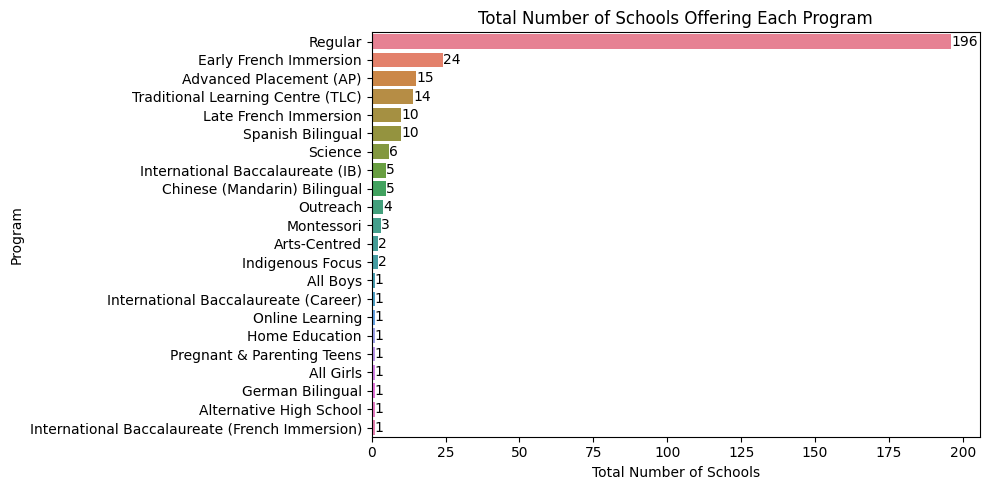

In [36]:
# Calculate the sums of the binary columns
program_sums = schools[program_columns].sum()

# Convert the sums to a DataFrame for plotting
program_sums_df = program_sums.reset_index()
program_sums_df.columns = ['Program', 'Total']

# Sort the DataFrame by the 'Total' column to order the bars
program_sums_df = program_sums_df.sort_values('Total', ascending=False)

# Plot using Seaborn's barplot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
ax = sns.barplot(
    x='Total',
    y='Program',
    data=program_sums_df,
    hue = 'Program',
    legend= False,
    #palette='coolwarm'  # Choose a color palette
)

print(program_sums_df)

# Set the title and labels of the plot
ax.set_title('Total Number of Schools Offering Each Program')
ax.set_xlabel('Total Number of Schools')
ax.set_ylabel('Program')

# Annotate each bar with the value of x
for p in ax.patches:
    ax.text(
        p.get_width(),  # X position to place the text
        p.get_y() + p.get_height() / 2,  # Y position (middle of the bar)
        int(p.get_width()),  # Text to display (x value, rounded to integer)
        va='center'  # Vertical alignment
    )

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

### Most Common Programs
- **Regular Program**: With 196 schools offering a standard curriculum, this is by far the most common program. It serves as the backbone of the educational system, ensuring accessibility to basic education for the majority of students.
- **Early French Immersion**: As the second most offered program with 24 schools, Early French Immersion is relatively popular, suggesting a demand for bilingual education starting at an early age.

### Specialized Programs
- **Advanced Placement (AP)** and **International Baccalaureate (IB)**: These programs, offered in 15 and 5 schools respectively, cater to students seeking advanced academic challenges and international curriculum standards.
- **Traditional Learning Centre (TLC)**: With 14 schools offering this program, there is a moderate demand for an education style characterized by structured learning and a focus on character education.
- **Late French Immersion** and **Spanish Bilingual**: Each present in 10 schools, indicating a continued interest in language immersion programs beyond the early years.

### Unique and Focused Programs
- A number of programs are offered in less than 10 schools, representing specialized or niche preferences within the educational landscape:
  - **Science Program**: Offered in 6 schools, highlighting a focus on STEM education.
  - **Chinese (Mandarin) Bilingual**: Available in 5 schools, reflecting community interest in Mandarin language acquisition.
  - **Outreach Programs**: Found in 4 schools, which may be aimed at providing education to underserved or non-traditional student populations.
  - **Montessori**: With 3 schools, suggesting an alternative approach to education is available, albeit in limited locations.

### Least Common Programs
- Several programs are only available in 1 or 2 schools, indicating highly specialized education options that may cater to specific populations or educational philosophies:
  - **Arts-Centred, Indigenous Focus, All Boys, All Girls, German Bilingual, Home Education, Pregnant & Parenting Teens, Alternative High School, International Baccalaureate (Career), Online Learning**, and **International Baccalaureate (French Immersion)**.

### Observations
- The variety in language immersion and bilingual programs points towards a multicultural student body with interests in global languages and cultures.
- The presence of advanced academic programs like AP and IB indicates alternative opportunities for academic excellence and preparation for higher education.
- Unique and focused programs, although fewer in number, provide diverse educational pathways that can accommodate different learning styles and needs.


Out of curiosity, I want to see how schools offering these alternative programs perform in terms of `school_rating`. However, it's important to note that these insights are constrained by the limited data set, with only 110 schools out of 250 having a rating.

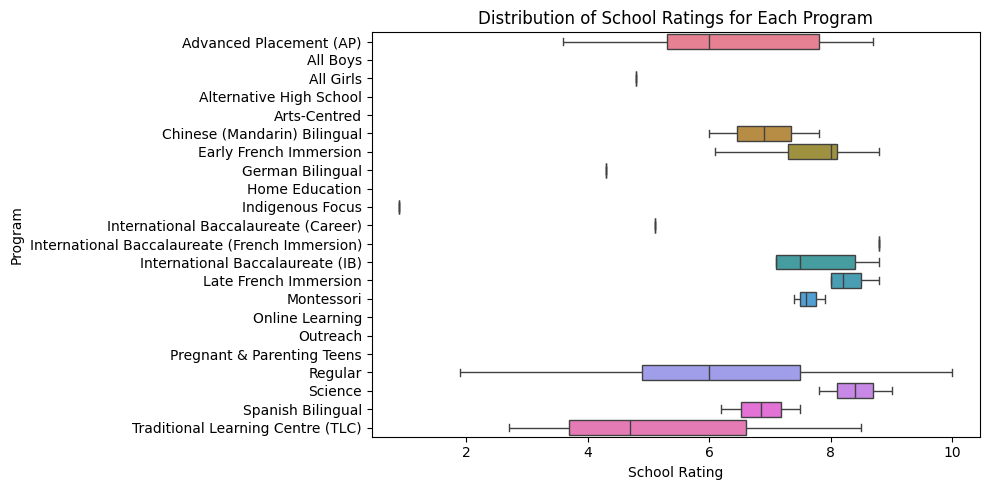

In [37]:
# First, melt my DataFrame to long format for the relevant columns including 'school_rating'
long_format = schools.melt(id_vars=['school_rating'], value_vars=program_columns, var_name='Program', value_name='Flag')

# Now we only keep the rows where the program is offered (i.e., Flag == 1) and 'school_rating' is not NaN
long_format = long_format[(long_format['Flag'] == 1) & (long_format['school_rating'].notna())]

# Plot using Seaborn's boxplot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
ax = sns.boxplot(
    y='Program',
    x='school_rating',
    data=long_format,
    hue = 'Program',
    legend = False,
    order=program_columns,  # Maintain the order of programs as in the list
    showfliers = False
)

# Set the title and labels of the plot
ax.set_title('Distribution of School Ratings for Each Program')
ax.set_xlabel('School Rating')
ax.set_ylabel('Program')

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
long_format.tail(10)

school_rating                            Program  Flag
4737            7.9                            Regular     1
4738            3.3                            Regular     1
4739            5.4                            Regular     1
4870            7.8                            Science     1
4879            9.0                            Science     1
5162            6.2                  Spanish Bilingual     1
5241            7.5                  Spanish Bilingual     1
5266            8.5  Traditional Learning Centre (TLC)     1
5296            2.7  Traditional Learning Centre (TLC)     1
5345            4.7  Traditional Learning Centre (TLC)     1

In [39]:
long_format.groupby(['Program'])['school_rating'].describe()

count      mean       std  \
Program                                                                     
Advanced Placement (AP)                          13.0  6.253846  1.600841   
All Girls                                         1.0  4.800000       NaN   
Chinese (Mandarin) Bilingual                      2.0  6.900000  1.272792   
Early French Immersion                            8.0  7.250000  1.889822   
German Bilingual                                  1.0  4.300000       NaN   
Indigenous Focus                                  1.0  0.900000       NaN   
International Baccalaureate (Career)              1.0  5.100000       NaN   
International Baccalaureate (French Immersion)    1.0  8.800000       NaN   
International Baccalaureate (IB)                  5.0  7.380000  1.444645   
Late French Immersion                             4.0  8.300000  0.382971   
Montessori                                        3.0  7.633333  0.251661   
Regular                                         101.0  5.944554  1.829452   
Science                                           2.0  8.400000  0.848528   
Spanish Bilingual                                 2.0  6.850000  0.919239   
Traditional Learning Centre (TLC)                 3.0  5.300000  2.946184   

                                                min    25%   50%    75%   max  
Program                                                                        
Advanced Placement (AP)                         3.6  5.300  6.00  7.800   8.7  
All Girls                                       4.8  4.800  4.80  4.800   4.8  
Chinese (Mandarin) Bilingual                    6.0  6.450  6.90  7.350   7.8  
Early French Immersion                          3.0  7.300  8.00  8.100   8.8  
German Bilingual                                4.3  4.300  4.30  4.300   4.3  
Indigenous Focus                                0.9  0.900  0.90  0.900   0.9  
International Baccalaureate (Career)            5.1  5.100  5.10  5.100   5.1  
International Baccalaureate (French Immersion)  8.8  8.800  8.80  8.800   8.8  
International Baccalaureate (IB)                5.1  7.100  7.50  8.400   8.8  
Late French Immersion                           8.0  8.000  8.20  8.500   8.8  
Montessori                                      7.4  7.500  7.60  7.750   7.9  
Regular                                         1.9  4.900  6.00  7.500  10.0  
Science                                         7.8  8.100  8.40  8.700   9.0  
Spanish Bilingual                               6.2  6.525  6.85  7.175   7.5  
Traditional Learning Centre (TLC)               2.7  3.700  4.70  6.600   8.5

- **Regular Program**: With 101 data points and an average rating of 5.94, this program is the most well-represented in the dataset and can be considered the baseline for comparison.
- **Early French Immersion**: A well-represented program with 8 data points and a higher-than-average mean rating of 7.25, indicating a tendency toward positive performance.
- **Advanced Placement (AP)**: Although it has 13 data points, the wide range from 3.6 to 8.7 in ratings suggests significant variability in program performance or ratings methodology.

### Programs with Inadequate Data
- **All Girls, German Bilingual, Indigenous Focus, International Baccalaureate (Career), International Baccalaureate (French Immersion), Montessori, Science, Spanish Bilingual, and Traditional Learning Centre (TLC)**: These programs have less than 5 data points, rendering the data inadequate for drawing meaningful conclusions.
  - **Science Program**: Despite inadequate data, it has a high mean rating of 8.4, which could indicate strong performance but requires more data for validation.
  - **Indigenous Focus**: The lowest rating at 0.9, but the single data point makes it impossible to evaluate the program's overall effectiveness.

### Interdependency of Program Ratings
- It is important to note that the performance of alternative programs may be influenced by the performance of other programs offered by the same schools. This interdependency can complicate the interpretation of ratings, as a school's overall performance may not accurately reflect the quality of individual programs.

- Nevertheless, there are still interesting observations!

## 7. Does my place of residence impact my likelihood of gaining admission to any CBE schools? What if I also consider the safety of the community?

CBE has a lottery process that is used to determine acceptance when schools cannot accommodate all students who register. The lottery process, outlines the priorities for acceptance as follows: 

**Priority 1**  

Students residing within the walk zone who have a sibling that will be attending the same program in the same school, concurrently  

**Priority 2**

Students living outside the walk zone who will have a sibling in the same program in the same school at the same time OR 

Students living within the walk zone who do not have a sibling in the school  

**Priority 3**

All other students living in the designated attendance area 

(source: https://cbe.ab.ca/registration/registration/lottery/Pages/Lottery-Process.aspx)

So it is clear that residing in the walk zones will grant your child higher chance of admission when lottery is required. 

In [40]:
def get_catchment(zone_type, conn):

    df_z = pd.read_sql_query(f'''SELECT s.school_id, s.name, z.polygon_number, z.lat_coordinate, z.long_coordinate
                                    FROM {zone_type}s z
                                    INNER JOIN schools s on s.school_id = z.school_id
                                    ''', conn)

    return gpd.GeoDataFrame(transform_to_geometry(df_z),
                                    geometry='geometry', 
                                    crs="EPSG:4326")
    

In [41]:
# load the catchment data from database
with sqlite3.connect('database.db') as conn:
    walk_zones = get_catchment('walk_zone',conn)
    attendance_areas = get_catchment('attendance_area',conn)

In [42]:
attendance_areas.head()

school_id                       name  \
0          6            Richmond School   
1          7  Alexander Ferguson School   
2          8      Jennie Elliott School   
3          9           Killarney School   
4         11            Altadore School   

                                            geometry  
0  POLYGON ((-114.11123 51.03783, -114.11324 51.0...  
1  POLYGON ((-114.12244 51.04949, -114.12247 51.0...  
2  POLYGON ((-114.11798 51.00871, -114.12142 51.0...  
3  POLYGON ((-113.93496 51.18354, -113.93525 51.1...  
4  POLYGON ((-114.11799 51.01611, -114.11805 51.0...

In [43]:
walk_zones = walk_zones.merge(right=schools,how ='inner',on='school_id')
attendance_areas=attendance_areas.merge(right=schools,how ='inner',on='school_id')

In [44]:
# import geospatial data on community crime
community_crime = gpd.read_file("community_boundaries/community_crime.geojson")

In [45]:
walk_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 61 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   school_id                                       237 non-null    int64   
 1   name_x                                          237 non-null    object  
 2   geometry                                        237 non-null    geometry
 3   name_y                                          237 non-null    object  
 4   address                                         237 non-null    object  
 5   school_hour                                     237 non-null    object  
 6   grades                                          237 non-null    object  
 7   ward                                            237 non-null    object  
 8   area                                            237 non-null    object  
 9   total_enrolment         

In [46]:
import json

# Function to convert any non-scalar type to a JSON string
def convert_to_json_if_list(value):
    if isinstance(value, list):
        return json.dumps(value)
    return value

# Apply this function to each column in the GeoDataFrame
for column in walk_zones.columns:
    walk_zones[column] = walk_zones[column].apply(convert_to_json_if_list)

# Now try saving to a file again
#walk_zones.to_file('walk_zones.geojson', driver='GeoJSON')


c:\Users\smart\anaconda3\envs\py310\lib\site-packages\geopandas\geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
from folium.features import GeoJsonTooltip
from folium.plugins import GroupedLayerControl
from branca.colormap import linear

# Create a base map
m = folium.Map(location=[51,-114], tiles="Cartodb Positron", zoom_start=10)

# Preparing colour map for community boundary
colormap = linear.Reds_09.scale(
    community_crime.crime_count.min(), community_crime.crime_count.max()
)

crime_count_dict = community_crime.set_index('row_id')['crime_count']

# add layer for community boundary and crime rate
folium.GeoJson(
    community_crime,
    name="community crime",
    style_function=lambda feature: {
        "fillColor": colormap(crime_count_dict[feature['properties']["row_id"]]),
        "color": "grey",
        "weight": 1,
        "fillOpacity": 0.7,
        "opacity": 0.3
    },
    
    tooltip = GeoJsonTooltip(
        fields=['sector', 'name','class', 'srg', 'comm_structure', 'crime_count'],
        aliases=['Sector: ', 'Community: ','Class: ','Development Level: ','Structure: ', 'Crime Count: '],
        localize=True
    ),
    highlight_function=lambda feature: {
        'fillColor':colormap(crime_count_dict[feature['properties']["row_id"]]),
        'color': 'grey',  # Outline color when highlighted
        'weight': 1.2,
        'fillOpacity': 1
    }
).add_to(m)

# Add the colormap to the map as a legend
colormap.caption = "Crime Count Intensity"
colormap.add_to(m)

# Generate a sequential color palette with seaborn
palette = sns.color_palette("viridis", 4).as_hex()  # 4 represents the number of school groups

# Update the colors dictionary to use the seaborn color palette
colors = {
    'early_childhood': palette[3],  # Lighter color
    'elementary': palette[2],
    'junior_high': palette[1],
    'senior_high': palette[0]  # Darker color
}

# Initialize dictionaries for layers
walk_zone_layers = {}
attendance_area_layers = {}

# Function to create a folium layer from a GeoDataFrame
def create_layer(gdf, color, group_name):
    layer = folium.FeatureGroup(name=group_name,show=False)
    folium.GeoJson(
        gdf,
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'grey',
            'weight': 1,
            'fillOpacity': 0.5
        },
        tooltip=GeoJsonTooltip(
        fields=[
            'name_x', 
            'grades', 
            'school_rating', 
            'school_rank', 
            'total_enrolment',
            'address', 
            'school_hour',
            'programs_list', 
            'lottery_requirement', 
            'lottery_programs',  
            'kindergarten_enrolment', 
            'grade_1_enrolment', 
            'grade_2_enrolment',
            'grade_3_enrolment', 
            'grade_4_enrolment', 
            'grade_5_enrolment',
            'grade_6_enrolment', 
            'grade_7_enrolment', 
            'grade_8_enrolment',
            'grade_9_enrolment', 
            'grade_10_enrolment', 
            'grade_11_enrolment',
            'grade_12_enrolment',
        ],
        aliases=[
            'School: ', 
            'Grades: ', 
            'Rating: ', 
            'Rank: ', 
            'Total Enrolment: ',
            'Address: ', 
            'School Hour: ',
            'Programs List: ', 
            'Lottery Requirement: ', 
            'Lottery Programs: ', 
            'Kindergarten Enrolment: ', 
            'Grade 1 Enrolment: ', 
            'Grade 2 Enrolment: ',
            'Grade 3 Enrolment: ', 
            'Grade 4 Enrolment: ', 
            'Grade 5 Enrolment: ',
            'Grade 6 Enrolment: ', 
            'Grade 7 Enrolment: ', 
            'Grade 8 Enrolment: ',
            'Grade 9 Enrolment: ', 
            'Grade 10 Enrolment: ', 
            'Grade 11 Enrolment: ',
            'Grade 12 Enrolment: ', 
        ],
        localize=True
        ),
        highlight_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 3,
            'fillOpacity': 0.8
        }
    ).add_to(layer)
    return layer

# Loop through each school group and create a layer
for group in ['early_childhood', 'elementary', 'junior_high', 'senior_high']:
    # Filter the GeoDataFrame for schools that offer the current group
    walk_zones_group = walk_zones[walk_zones[group]]
    attendance_areas_group = attendance_areas[attendance_areas[group]]
    
    # Create the layer for walk zones and attendance areas
    walk_zone_layers[group] = create_layer(walk_zones_group, colors[group], group.capitalize() + ' Walk Zone')
    attendance_area_layers[group] = create_layer(attendance_areas_group, colors[group], group.capitalize() + ' Attendance Area')
    
    # Add the layers to the map
    walk_zone_layers[group].add_to(m)
    attendance_area_layers[group].add_to(m)

#Add geoencoder
folium.plugins.Geocoder().add_to(m)

# Add Layer Control to toggle layers
GroupedLayerControl(
    groups={
        'Walk Zone': [layer for layer in walk_zone_layers.values()],
        'Attendance Area': [layer for layer in attendance_area_layers.values()]
    },
    collapsed=False,
    exclusive_groups=False,
).add_to(m)

#save it as a useful tool
m.save('tools/catchment.html')

#display
m

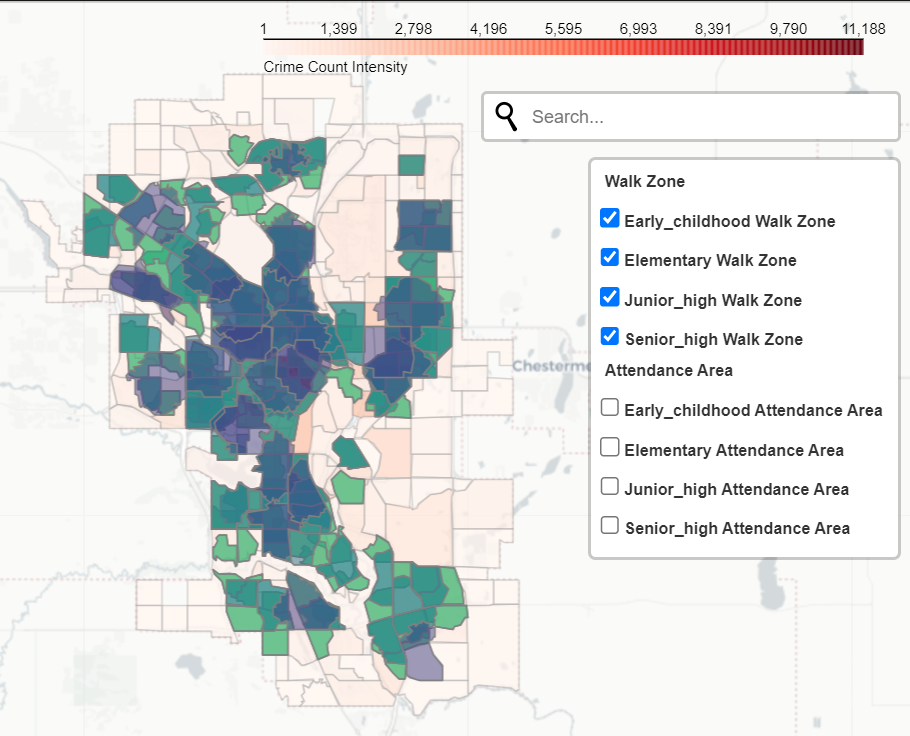

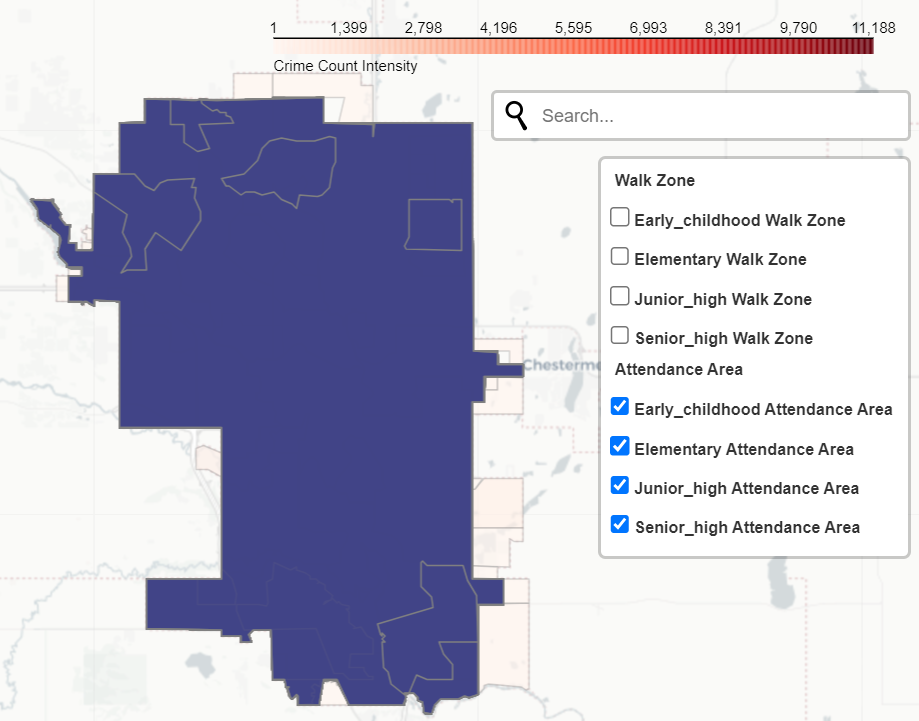

(saved as image to reduce file size.
The interactive version of the plot is available at path: *tools/catchment.html*)

### Attendance Areas

- **Extensive Coverage:**
  - CBE schools serve a wide range of communities in Calgary, ensuring comprehensive accessibility for most city areas.
  
- **Peripheral Exceptions:**
  - Certain outlying communities, such as Heritage Pointe in the South, Janet from the East, and Elbow Valley from the West, are not within the CBE school attendance areas.

### Walk Zones

- **Incomplete Coverage:**
  - Walk zones are notably less comprehensive than overall attendance areas. Central and Western parts of Calgary benefit from more extensive walk zone coverage compared to the Southeast.

- **Historical Development Influence:**
  - The disparity in walk zone coverage may reflect historical development patterns, with older, more established areas having a higher density of schools, while newer developing areas are yet to catch up.

### Trends Across School Divisions

- **Shift in Walk Zones:**
  - Observing different divisions, from elementary to secondary, there's a discernible shift of walk zones towards Central and Western Calgary.
  
- **Reason for Shift:**
  - This shift could likely be due to the lower number of secondary schools, which necessitates a concentration of walk zones where these schools are located.


## 8. How does my rental listings data look like?

### 8.1 import from database

To simplify the analysis, I am only interested in property type 'Condo Unit', 'Basement', 'House', 'Townhouse' and 'Apartment'.

In [48]:
query_rental_listings = '''
SELECT
    id,
    community,
    latitude,
    longitude,
    type,
    price,
    beds,
    has_den,
    sq_feet,
    baths,
    cats,
    dogs,
    activation_date,
    last_update,
    is_active
    
FROM rental_listings
WHERE type IN ('Condo Unit', 'Basement', 'House', 'Townhouse', 'Apartment');
'''
with sqlite3.connect('database.db') as conn:
    rental_listings = pd.read_sql_query(query_rental_listings,conn)



In [49]:
rental_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11372 entries, 0 to 11371
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               11372 non-null  int64  
 1   community        11372 non-null  object 
 2   latitude         11372 non-null  float64
 3   longitude        11372 non-null  float64
 4   type             11372 non-null  object 
 5   price            11372 non-null  int64  
 6   beds             11370 non-null  float64
 7   has_den          11372 non-null  int64  
 8   sq_feet          9224 non-null   float64
 9   baths            11372 non-null  float64
 10  cats             11372 non-null  int64  
 11  dogs             11372 non-null  int64  
 12  activation_date  11372 non-null  object 
 13  last_update      11372 non-null  object 
 14  is_active        11372 non-null  int64  
dtypes: float64(5), int64(6), object(4)
memory usage: 1.3+ MB


- After over 4 months of running my data pipeline, I have over 11,000 rental listings in my database.

### 8.2 Convert columns to correct data types

In [50]:
# Convert 'community' and 'type' to categorical columns
rental_listings['community'] = rental_listings['community'].astype('category')
rental_listings['type'] = rental_listings['type'].astype('category')

# Convert 'activation_date' and 'last_update' to datetime
rental_listings['activation_date'] = pd.to_datetime(rental_listings['activation_date'])
rental_listings['last_update'] = pd.to_datetime(rental_listings['last_update'])

# Convert 'has_den', 'cats', 'dogs', 'is_active' to boolean
rental_listings['has_den'] = rental_listings['has_den'].astype('bool')
rental_listings['cats'] = rental_listings['cats'].astype('bool')
rental_listings['dogs'] = rental_listings['dogs'].astype('bool')
rental_listings['is_active'] = rental_listings['is_active'].astype('bool')

### 8.3 Overview by scatter matrix

In [51]:
rental_listings.describe()

id      latitude     longitude           price  \
count   11372.000000  11372.000000  11372.000000    11372.000000   
mean   454987.331604     51.043219   -114.067044     2268.464210   
min       456.000000     50.851366   -114.454338        0.000000   
25%    416993.250000     51.006960   -114.114046     1650.000000   
50%    541028.500000     51.047062   -114.074838     2050.000000   
75%    556216.250000     51.117735   -114.020702     2500.000000   
max    565646.000000     53.440487   -113.631729  1000000.000000   
std    158347.613895      0.097018      0.079216     9390.231049   

               beds       sq_feet         baths  \
count  11370.000000   9224.000000  11372.000000   
mean       2.097098   1105.110256      1.671782   
min        0.000000      0.000000      0.000000   
25%        1.000000    715.000000      1.000000   
50%        2.000000    950.000000      1.000000   
75%        3.000000   1316.000000      2.500000   
max        7.000000  14000.000000      7.500000   
std        1.021917    576.779241      0.813097   

                     activation_date                    last_update  
count                          11372                          11372  
mean   2024-02-12 00:20:31.290977536  2024-03-12 12:24:49.916373248  
min              2023-12-30 15:00:58            2024-01-03 07:51:57  
25%              2023-12-30 15:00:58            2024-02-10 10:19:47  
50%              2024-02-08 07:37:56            2024-03-19 07:00:15  
75%              2024-03-16 09:28:39            2024-04-19 07:02:12  
max              2024-04-20 08:40:18            2024-04-20 08:40:19  
std                              NaN                            NaN

From the maximum price of 1000000 and 14000 sq feet, there are obviously outliers. I decided to remove them. To allow for greater variability, I opted for the 3x IQR rule instead of the classic 1.5x.

In [52]:
# Function to calculate lower and upper bounds for outlier detection using the 3x IQR rule
def outlier_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return lower_bound, upper_bound

# Calculate bounds for 'price'
price_lower, price_upper = outlier_bounds(rental_listings['price'])

# Calculate bounds for 'sq_feet'
sq_feet_lower, sq_feet_upper = outlier_bounds(rental_listings['sq_feet'])

# Filter out outliers
filtered_listings = rental_listings[
    (rental_listings['price'] >= price_lower) & (rental_listings['price'] <= price_upper) &
    (rental_listings['sq_feet'] >= sq_feet_lower) & (rental_listings['sq_feet'] <= sq_feet_upper)
].copy()


In [53]:
filtered_listings.describe()

id     latitude    longitude        price         beds  \
count    9124.000000  9124.000000  9124.000000  9124.000000  9124.000000   
mean   448712.757453    51.042221  -114.068369  2179.659908     2.096230   
min       456.000000    50.851384  -114.454338     0.000000     0.000000   
25%    403952.500000    51.006605  -114.113624  1700.000000     1.000000   
50%    536213.000000    51.046293  -114.075188  2100.000000     2.000000   
75%    555870.250000    51.112500  -114.026658  2500.000000     3.000000   
max    565646.000000    53.440487  -113.631729  5000.000000     7.000000   
std    162383.045355     0.097071     0.077891   661.119575     1.001342   

           sq_feet        baths                activation_date  \
count  9124.000000  9124.000000                           9124   
mean   1079.629658     1.680897  2024-02-12 08:06:56.894454016   
min       0.000000     0.000000            2023-12-30 15:00:58   
25%     710.000000     1.000000            2024-01-02 08:00:12   
50%     947.000000     1.000000            2024-02-08 07:37:56   
75%    1300.000000     2.500000            2024-03-16 09:28:39   
max    3100.000000     5.000000            2024-04-20 08:40:18   
std     496.871251     0.796014                            NaN   

                         last_update  
count                           9124  
mean   2024-03-12 20:13:51.628232960  
min              2024-01-03 07:51:57  
25%              2024-02-12 14:40:01  
50%              2024-03-19 07:00:15  
75%              2024-04-19 07:02:12  
max              2024-04-20 08:40:19  
std                              NaN

After dropping the outliers, the number of rental listings decreased from 11,372 to 9,124. This is fine to facilitate the plotting of pairplot below:

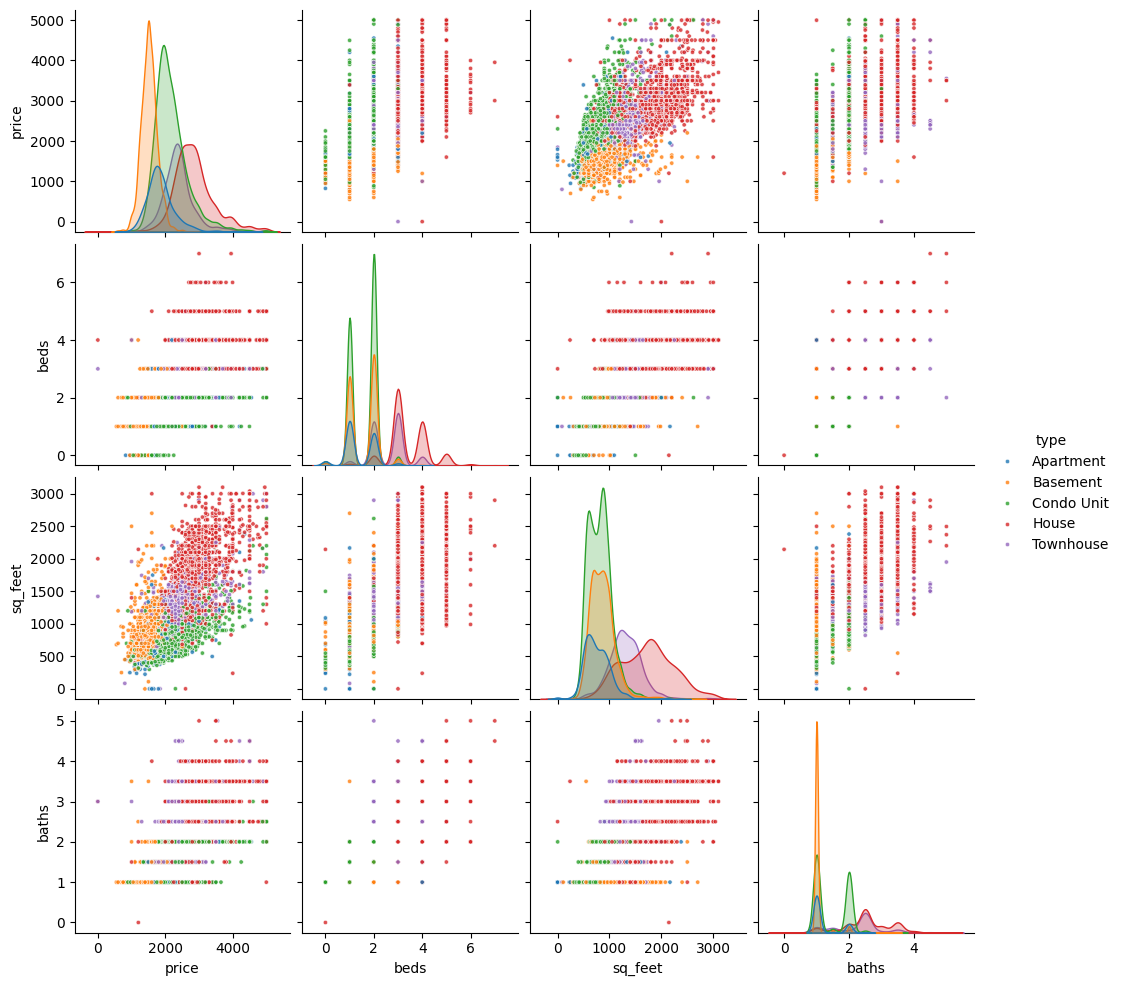

In [54]:
pairplot_fig = sns.pairplot(
    filtered_listings[['price','beds','sq_feet','baths','type']],
    hue='type',    
    plot_kws=dict(alpha=0.8, s=10, edgecolor='white', linewidth=0.5),  # Adjust alpha for transparency, s for size
    diag_kind='kde',  # Kernel density estimate plots for the diagonal
    diag_kws=dict(fill=True)  # Shade the kde plots
)

# Show the plot
plt.show()

- **Positive Relationship with Size and Capacity:**
  - The `price` of rental listings shows a positive correlation with both `beds`,`sq_feet` and `baths`, indicating that larger and more spacious properties tend to be priced higher.

- **Correlation Between Space and Amenities:**
  - As expected, the `sq_feet` measurement correlates positively with `beds` and `baths`. This trend supports the intuitive observation that larger houses usually offer more bedrooms and bathrooms.

- **Range of Beds and Bathrooms:**
  - The majority of rental listings feature between 1 to 4 beds and 1 to 2 bathrooms, suggesting that these configurations meet the standard demand in the rental market.

### 8.4 How does the price differ among different property types?

In [55]:
filtered_listings.groupby(['type'], observed=True)['price'].describe()

count         mean         std    min     25%     50%     75%  \
type                                                                         
Apartment    952.0  1862.801471  430.818063  825.0  1600.0  1800.0  2000.0   
Basement    1942.0  1517.537590  242.403597  550.0  1352.5  1500.0  1650.0   
Condo Unit  3019.0  2179.793309  508.855343  850.0  1850.0  2100.0  2400.0   
House       1897.0  2859.771218  603.804835    0.0  2500.0  2800.0  3150.0   
Townhouse   1314.0  2405.624049  503.368218    1.0  2100.0  2350.0  2595.0   

               max  
type                
Apartment   4550.0  
Basement    2850.0  
Condo Unit  5000.0  
House       5000.0  
Townhouse   5000.0

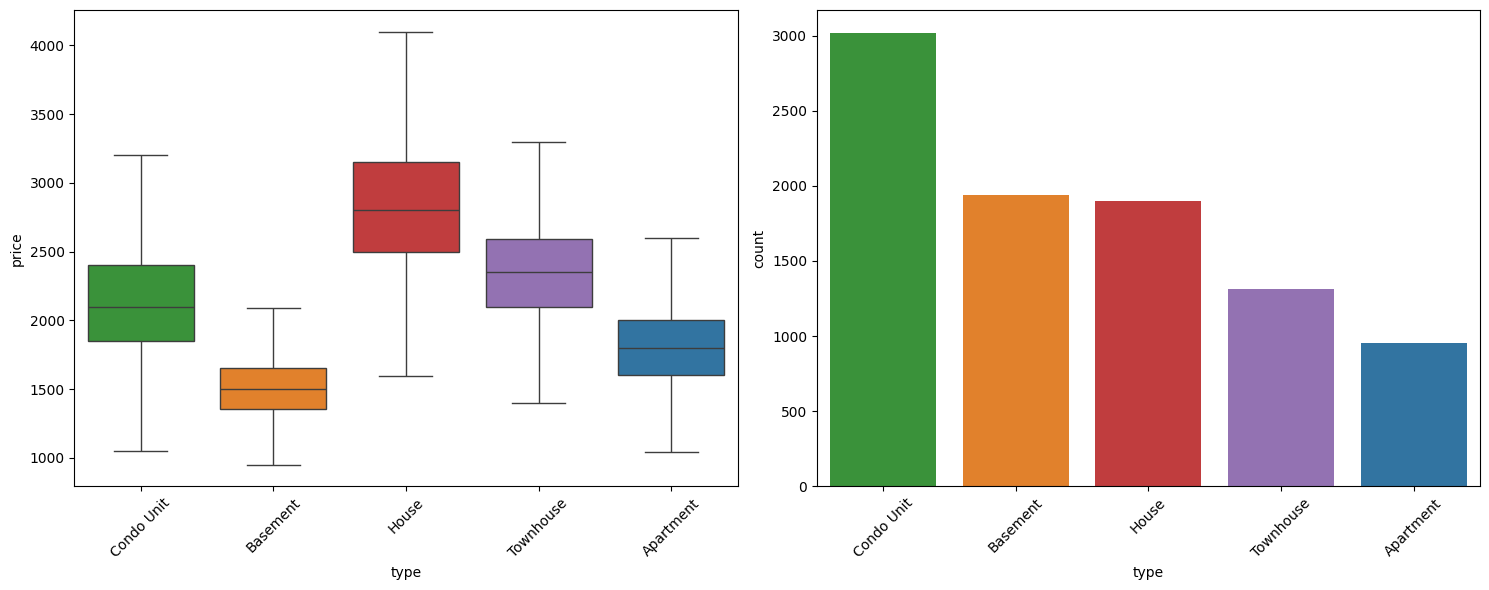

In [56]:
# Determine the order for plotting based on the 'type' value counts
order = filtered_listings['type'].value_counts().sort_values(ascending=False).index

# Create a figure and two axes for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Boxplot on the left (axs[0])
sns.boxplot(x='type',
            y='price',
            data=filtered_listings,
            showfliers=False,
            hue='type',
            ax=axs[0],
            order=order)  # Order the boxplot
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Countplot on the right (axs[1])
sns.countplot(x='type',
              data=filtered_listings,
              hue='type',
              ax=axs[1],
              order=order)  # Order the countplot
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

Boxplot:
- There's a clear hierarchy in the average pricing, with `Houses` being the most expensive and `Basements` being the least.

In ascending order of median price:

- **Basements** are the most affordable option, with the lowest median price ($1,500) and a narrow price distribution, indicating less variability in what renters might expect to pay. 
- **Apartments** offer a mid-range option, with a moderate median price ($1,800) and a relatively tight price range, suggesting a consistent market.
- **Condo Units** present a higher median price ($2,100) than apartments, with a larger standard deviation, which reflects a wide variety of options and potentially upscale amenities.
- **Townhouses** strike a balance between price and space, with a median price ($2,350) lower than houses but higher than condos and apartments.
- **Houses** have the highest median price ($2,800), and the largest standard deviation and range, highlighting a diverse market that includes luxury options.


Histogram:
- This chart indicates that `Condo Units` are the most frequently listed property type, followed by `Basements` and `Houses`. 
- `Apartments` and `Townhouses` are less common in comparison to the other types.


### 8.5 Does allowing cats matter?

In [57]:
filtered_listings.groupby(['type','cats'], observed=True)['price'].describe()

count         mean         std     min     25%     50%  \
type       cats                                                             
Apartment  False   511.0  1859.246575  455.883510   950.0  1577.5  1800.0   
           True    441.0  1866.920635  400.291008   825.0  1650.0  1800.0   
Basement   False  1387.0  1512.574621  240.888772   600.0  1375.0  1500.0   
           True    555.0  1529.940541  245.929604   550.0  1350.0  1500.0   
Condo Unit False  1911.0  2172.325484  510.355591   850.0  1850.0  2095.0   
           True   1108.0  2192.673285  506.228326  1000.0  1850.0  2100.0   
House      False  1209.0  2824.338296  584.271968     0.0  2489.0  2770.0   
           True    688.0  2922.036337  632.316865  1200.0  2500.0  2800.0   
Townhouse  False   780.0  2379.108974  491.813583     1.0  2100.0  2300.0   
           True    534.0  2444.353933  517.812179  1069.0  2200.0  2400.0   

                     75%     max  
type       cats                   
Apartment  False  2000.0  4350.0  
           True   2000.0  4550.0  
Basement   False  1650.0  2600.0  
           True   1650.0  2850.0  
Condo Unit False  2400.0  5000.0  
           True   2400.0  5000.0  
House      False  3000.0  5000.0  
           True   3200.0  5000.0  
Townhouse  False  2500.0  5000.0  
           True   2600.0  5000.0

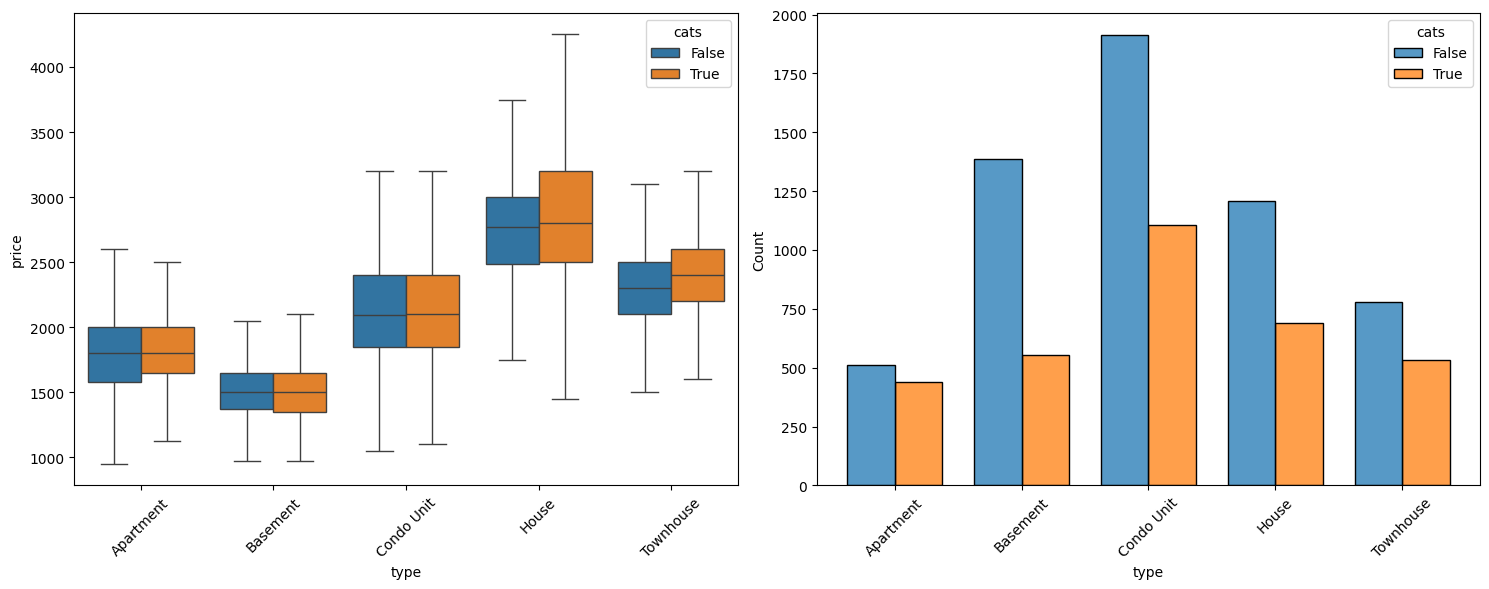

In [58]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Boxplot
sns.boxplot(x='type',
            y='price',
            data=filtered_listings,
            showfliers=False,
            hue='cats',
            ax=axs[0])  # Assign to the first axes
axs[0].tick_params(axis='x', rotation=45)

# Second subplot: Histogram
sns.histplot(data=filtered_listings,
             x='type',
             hue='cats',
             multiple='dodge',
             shrink =0.75,
             ax=axs[1])  # Assign to the second axes
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

- Rental prices for townhouses and houses tend to be higher when cats are allowed, which may suggest that landlords charge a premium for pet-friendly accommodations in these types of properties. This trend is not observed in apartments, basements, or condo units, where the difference in price based on cat policies is minimal.

- The data reveals that properties not allowing cats are more common across all types, indicating a general preference among landlords or potential restrictions related to pets.

### 8.5 Does allowing dogs matter?

In [59]:
filtered_listings.groupby(['type','dogs'], observed=True)['price'].describe()

count         mean         std     min     25%     50%  \
type       dogs                                                             
Apartment  False   597.0  1829.847571  449.813565   825.0  1545.0  1765.0   
           True    355.0  1918.219718  391.220721  1050.0  1699.0  1840.0   
Basement   False  1464.0  1505.133880  235.723107   550.0  1350.0  1500.0   
           True    478.0  1555.527197  258.381299   980.0  1400.0  1550.0   
Condo Unit False  1967.0  2147.432130  502.108086   850.0  1850.0  2050.0   
           True   1052.0  2240.301331  516.057398  1250.0  1900.0  2150.0   
House      False  1137.0  2793.499560  562.480715     0.0  2450.0  2750.0   
           True    760.0  2958.917105  648.670473  1200.0  2500.0  2865.0   
Townhouse  False   743.0  2344.480485  474.636117     1.0  2100.0  2300.0   
           True    571.0  2485.185639  528.383550  1069.0  2200.0  2400.0   

                     75%     max  
type       dogs                   
Apartment  False  2000.0  4350.0  
           True   2049.5  4550.0  
Basement   False  1650.0  2500.0  
           True   1700.0  2850.0  
Condo Unit False  2350.0  5000.0  
           True   2475.0  5000.0  
House      False  3000.0  5000.0  
           True   3250.0  5000.0  
Townhouse  False  2500.0  5000.0  
           True   2650.0  5000.0

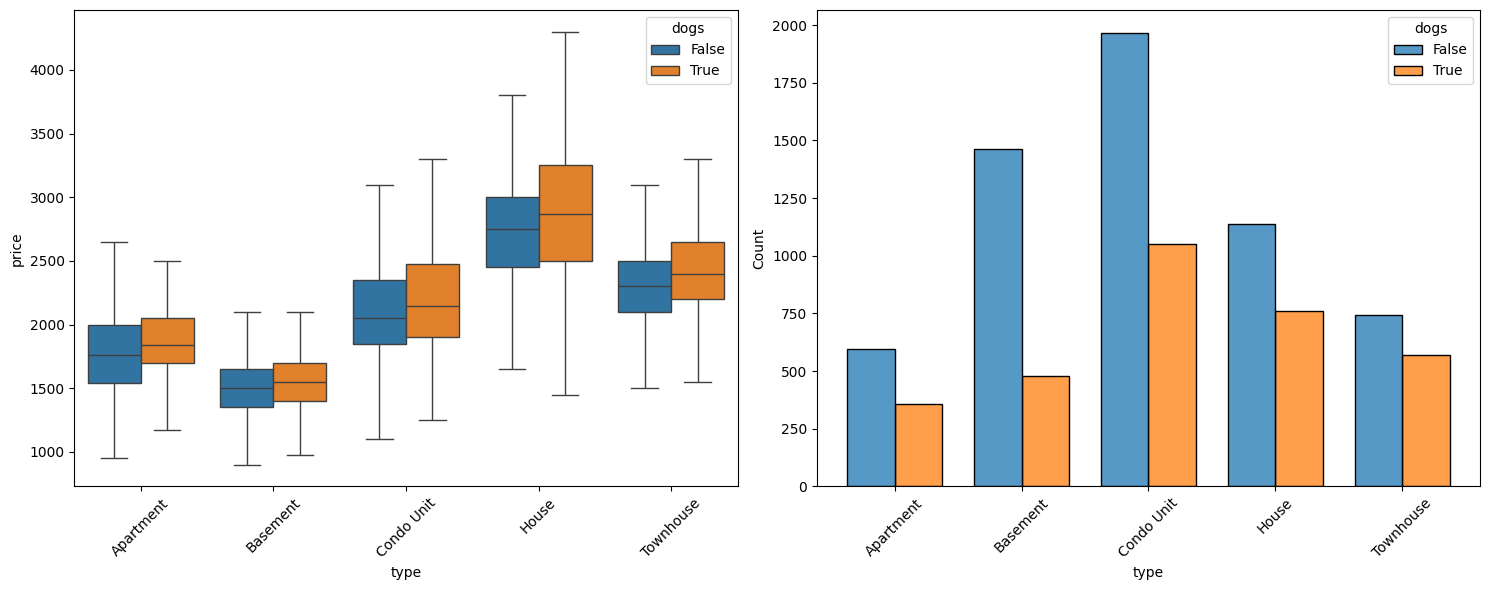

In [60]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Boxplot
sns.boxplot(x='type',
            y='price',
            data=filtered_listings,
            showfliers=False,
            hue='dogs',
            ax=axs[0])  # Assign to the first axes
axs[0].tick_params(axis='x', rotation=45)

# Second subplot: Histogram
sns.histplot(data=filtered_listings,
             x='type',
             hue='dogs',
             multiple='dodge',
             shrink =0.75,
             ax=axs[1])  # Assign to the second axes
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

- Apartments, condos, houses and townhouses show a noticeable increase in average rental prices when dogs are allowed, which could be attributed to potentially greater perceived risk or maintenance issues. This trend is less pronounced but still present in basements.

- Across all property types, there are more units that do not allow dogs compared to those that do, indicating a general trend of pet restrictions among landlords.


### 8.5 Does having a den matter?

In [61]:
filtered_listings.groupby(['type','has_den'], observed=True)['price'].describe()

count         mean         std     min     25%     50%  \
type       has_den                                                            
Apartment  False     884.0  1849.906109  430.341603   825.0  1599.0  1795.0   
           True       68.0  2030.441176  403.813515  1045.0  1798.0  2000.0   
Basement   False    1743.0  1515.142283  240.859343   550.0  1375.0  1500.0   
           True      199.0  1538.517588  255.204114   975.0  1350.0  1500.0   
Condo Unit False    2568.0  2153.042835  492.513662   850.0  1850.0  2050.0   
           True      451.0  2332.110865  570.544633  1495.0  1950.0  2190.0   
House      False    1367.0  2797.790783  587.257120     0.0  2450.0  2700.0   
           True      530.0  3019.633962  616.953858  1250.0  2600.0  2900.0   
Townhouse  False    1113.0  2373.631626  481.190368     1.0  2100.0  2350.0   
           True      201.0  2582.776119  582.078701  1500.0  2250.0  2495.0   

                       75%     max  
type       has_den                  
Apartment  False    2000.0  4550.0  
           True     2212.5  3400.0  
Basement   False    1650.0  2850.0  
           True     1725.0  2200.0  
Condo Unit False    2395.0  5000.0  
           True     2550.0  4500.0  
House      False    3000.0  5000.0  
           True     3300.0  5000.0  
Townhouse  False    2525.0  4900.0  
           True     2700.0  5000.0

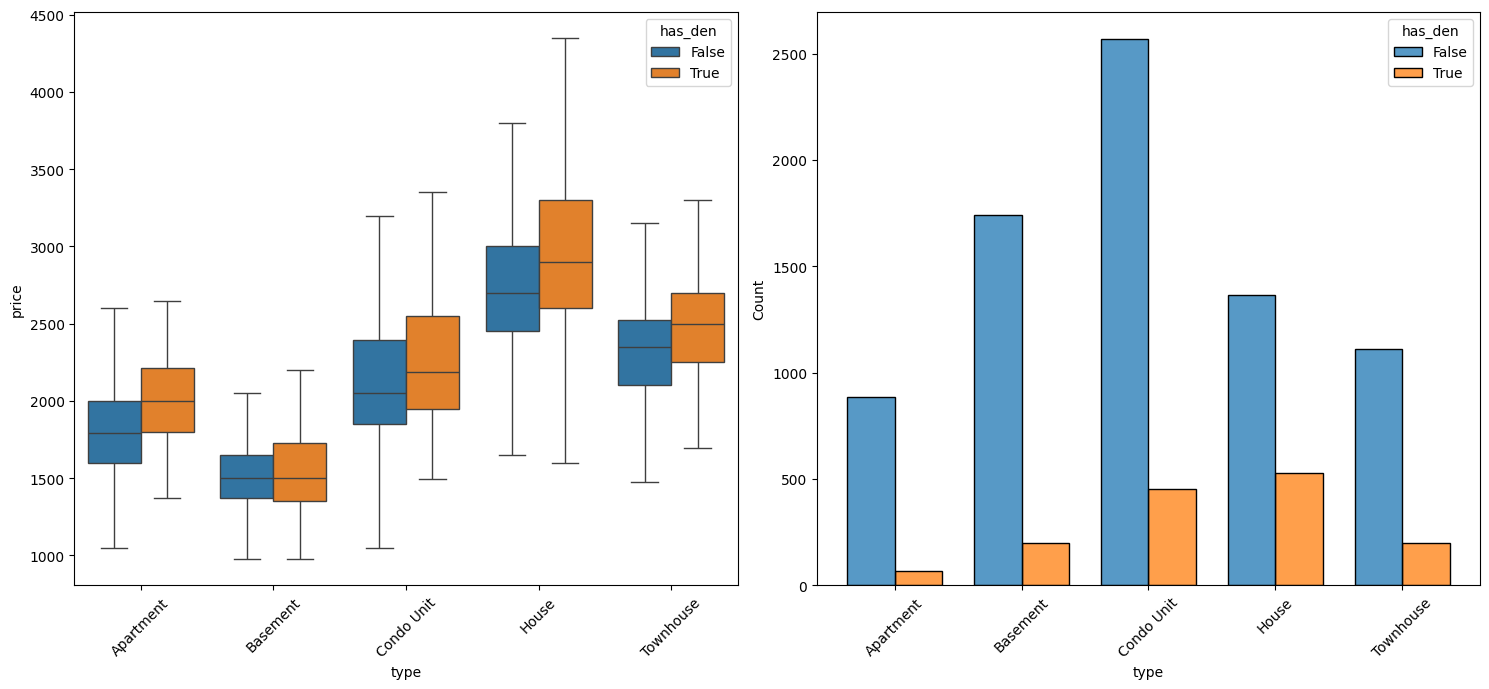

In [62]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# First subplot: Boxplot
sns.boxplot(x='type',
            y='price',
            data=filtered_listings,
            showfliers=False,
            hue='has_den',
            ax=axs[0])  # Assign to the first axes
axs[0].tick_params(axis='x', rotation=45)

# Second subplot: Histogram
sns.histplot(data=filtered_listings,
             x='type',
             hue='has_den',
             multiple='dodge',
             shrink =0.75,
             ax=axs[1])  # Assign to the second axes
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

- Apartments, condos, houses, and townhouses with a den generally command higher rental prices compared to those without. This suggests that additional features like a den add value and are priced accordingly.

- The presence of a den in basements shows a smaller increase in rental prices compared to other property types, yet still contributes to a slight price elevation.

- Across all types, the units with dens are significantly fewer than those without, indicating that dens are a less common feature but potentially desirable, reflecting in their higher pricing.


### 8.6 Does larger size always mean higher price?

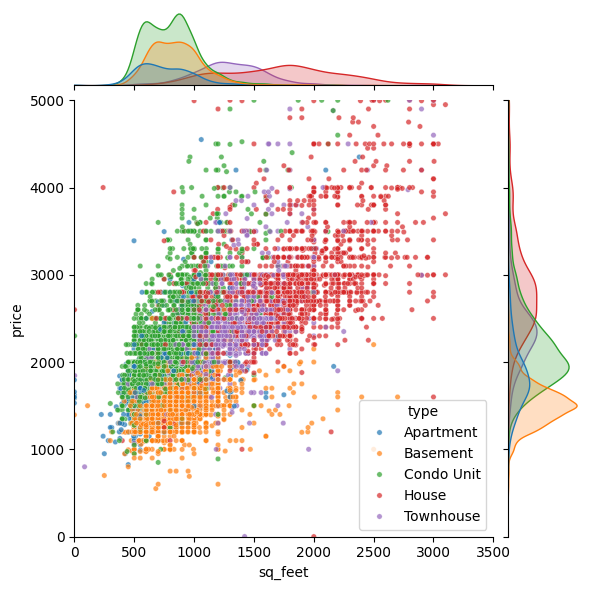

In [63]:
sns.jointplot(data=filtered_listings, 
              x="sq_feet",
              y="price", 
              hue="type",
              xlim=(0,3500),
              ylim=(0,5000),
              alpha=0.7,
              s=15)

- From this joint plot, it appears there is a positive relationship between `sq_feet` and `price`.
- **Condo**, **Basement**, **Townhouse** and **House** appears to aggregate as dintinct groups, whereas **Townhouse** seems to spread across the graph.

Let's take a closer look at the relationship between `price` and `sq_feet` across different types.

In [64]:
filtered_listings.groupby('type',observed = True)[['sq_feet','price']].describe()

sq_feet                                                        \
             count         mean         std  min     25%     50%     75%   
type                                                                       
Apartment    952.0   756.804622  246.695097  0.0   579.5   724.5   900.0   
Basement    1942.0   861.449537  249.126820  0.0   700.0   850.0  1000.0   
Condo Unit  3019.0   811.508778  233.163619  2.0   630.0   800.0   940.0   
House       1897.0  1732.443332  506.020803  1.0  1340.0  1750.0  2079.0   
Townhouse   1314.0  1309.541857  323.972644  2.0  1114.0  1300.0  1500.0   

                     price                                                  \
               max   count         mean         std    min     25%     50%   
type                                                                         
Apartment   2380.0   952.0  1862.801471  430.818063  825.0  1600.0  1800.0   
Basement    2700.0  1942.0  1517.537590  242.403597  550.0  1352.5  1500.0   
Condo Unit  2619.0  3019.0  2179.793309  508.855343  850.0  1850.0  2100.0   
House       3100.0  1897.0  2859.771218  603.804835    0.0  2500.0  2800.0   
Townhouse   3000.0  1314.0  2405.624049  503.368218    1.0  2100.0  2350.0   

                            
               75%     max  
type                        
Apartment   2000.0  4550.0  
Basement    1650.0  2850.0  
Condo Unit  2400.0  5000.0  
House       3150.0  5000.0  
Townhouse   2595.0  5000.0

In [65]:
filtered_listings.groupby('type',observed = True)[['sq_feet','price']].corr()

sq_feet     price
type                                  
Apartment  sq_feet  1.000000  0.532650
           price    0.532650  1.000000
Basement   sq_feet  1.000000  0.305282
           price    0.305282  1.000000
Condo Unit sq_feet  1.000000  0.644419
           price    0.644419  1.000000
House      sq_feet  1.000000  0.563538
           price    0.563538  1.000000
Townhouse  sq_feet  1.000000  0.634477
           price    0.634477  1.000000

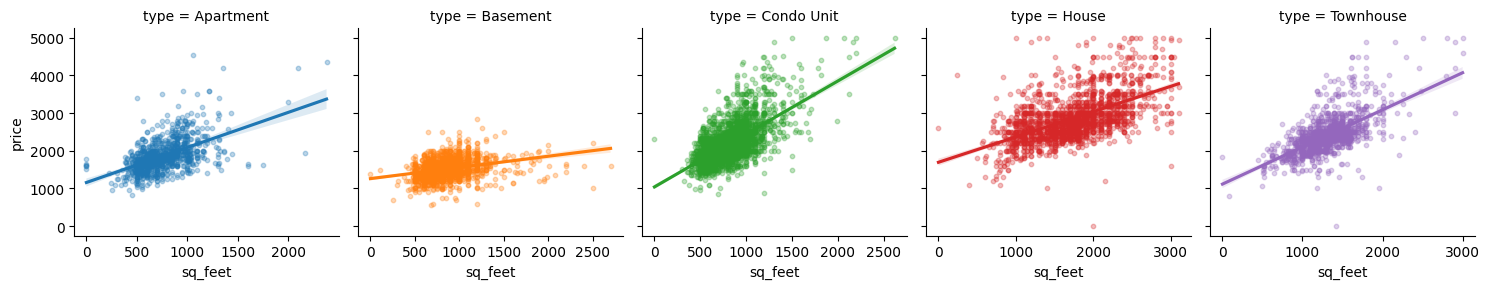

In [66]:
lm = sns.lmplot(x='sq_feet', y='price', 
                hue='type', 
                data=filtered_listings, 
                col ='type',
                #aspect=2,  # Aspect ratio of 2 (twice as wide as it is tall)
                height=3,  # Height of the plot in inches
                facet_kws=dict(sharex=False, sharey=True),
                scatter_kws={'alpha': 0.3, 's': 10},  # Adjust alpha for transparency and s for size
                )  

plt.show()

- Apartments show a moderate correlation. 

- Basements exhibit a very weak correlation. 

- Condo Units have a strong correlation. Larger condos typically command higher rental prices, reflecting their appeal in urban settings.

- Houses display the strongest correlation among the property types. This indicates that rental prices for houses are heavily influenced by their size.

- Townhouses also show a strong correlation. Size is a significant factor in determining rental prices, with larger townhouses usually costing more.

In summary, while a larger size generally correlates with higher rental prices, the strength of this relationship varies by property type, with houses and condos showing particularly strong correlations.

### 8.8 Will the size be different among different property types?

In [67]:
filtered_listings[filtered_listings['sq_feet'].notnull()].groupby('type',observed = True)['sq_feet'].describe()

count         mean         std  min     25%     50%     75%  \
type                                                                       
Apartment    952.0   756.804622  246.695097  0.0   579.5   724.5   900.0   
Basement    1942.0   861.449537  249.126820  0.0   700.0   850.0  1000.0   
Condo Unit  3019.0   811.508778  233.163619  2.0   630.0   800.0   940.0   
House       1897.0  1732.443332  506.020803  1.0  1340.0  1750.0  2079.0   
Townhouse   1314.0  1309.541857  323.972644  2.0  1114.0  1300.0  1500.0   

               max  
type                
Apartment   2380.0  
Basement    2700.0  
Condo Unit  2619.0  
House       3100.0  
Townhouse   3000.0

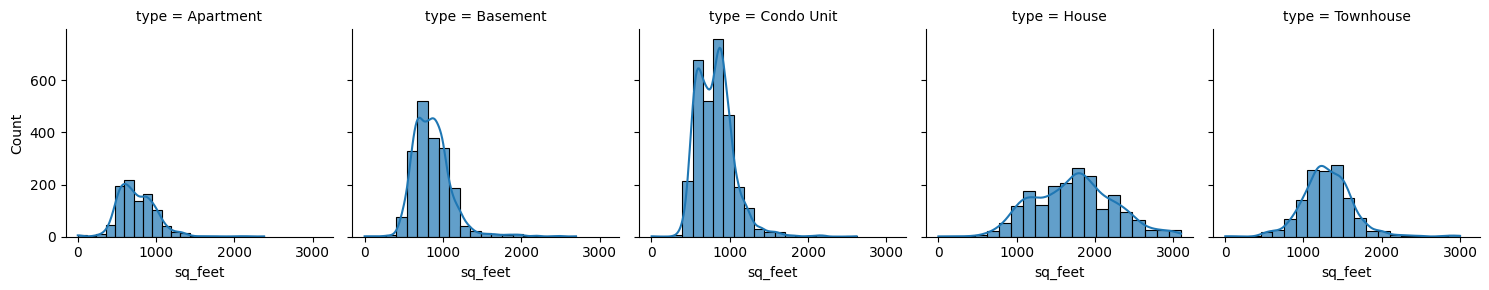

In [68]:

g = sns.FacetGrid(filtered_listings[filtered_listings['sq_feet'].notnull()], col="type") #col_wrap=3
g.map(sns.histplot, 'sq_feet',
    kde=True,      
    bins=20,     
    alpha=0.7,
    
)
plt.show()

**Apartments** have an average size of approximately 759 sq ft. These are typically the smallest units, which is common for apartments, especially in urban settings where space is at a premium.

**Basements** average around 862 sq ft. This size suggests that basements can be quite spacious, often similar in size to some apartments or even larger, depending on the overall size of the property above them.

**Condo** Units have an average size of about 812 sq ft. Condos vary widely in size, but the average suggests moderately sized units, which balance living space with the amenities and location advantages condos usually offer.

**Houses** show a significantly larger average size of 1734 sq ft. This is the largest average size among the property types listed, reflecting the typical expectation that houses offer more living space, including multiple bedrooms and additional amenities like yards and garages.

**Townhouses** have an average size of 1311 sq ft. This places them between condos and houses in terms of space, offering a middle ground with multiple floors and often several bedrooms, without the larger footprint of a standalone house.

### 8.9 Create ['days_on_market'] column, Box plot for ['active_duration'] by ['type']

In [69]:
# Only do this for inactive listings
filtered_listings['days_on_market'] = filtered_listings['last_update'] - filtered_listings['activation_date']

# Convert 'days_on_market' to a numerical value (i.e. days)
filtered_listings['days_on_market'] = filtered_listings['days_on_market'].dt.days


In [70]:
inactive_filtered_listings = filtered_listings[~filtered_listings['is_active']]
inactive_filtered_listings.shape

(6972, 16)

There are 6702 inactive listings in the database.

In [71]:
inactive_filtered_listings.groupby('type',observed = True)['days_on_market'].describe()

count       mean        std  min   25%   50%   75%    max
type                                                                  
Apartment    615.0  29.629268  28.206702  0.0   8.0  20.0  43.0  110.0
Basement    1500.0  27.656667  22.491154  0.0   9.0  22.0  41.0  111.0
Condo Unit  2340.0  25.424786  21.270583  0.0   9.0  19.0  35.0  111.0
House       1489.0  26.048355  21.222049  0.0  10.0  19.0  38.0  105.0
Townhouse   1028.0  28.065175  22.050015  0.0  11.0  22.0  40.0  109.0

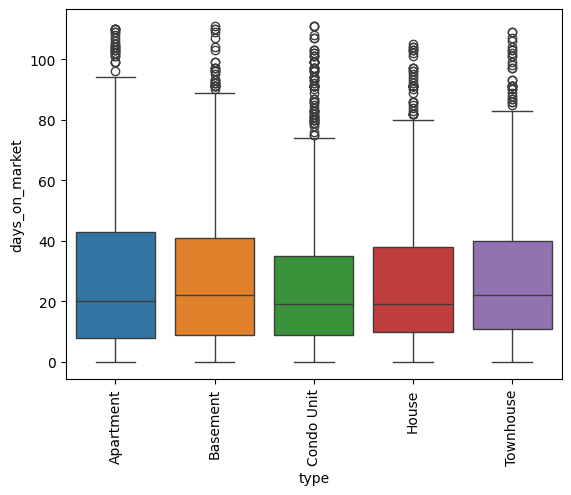

In [72]:


sns.boxplot(x='type',
            y='days_on_market',
            data=inactive_filtered_listings,
            hue = 'type'
            )
plt.xticks(rotation=90)
plt.show()

Days on market (DOM):

- **Apartments** and **Condo** Units have the shortest median DOM at 19 days, suggesting these types of properties are often rented relatively quickly, possibly due to their appeal in urban areas or efficient turnover processes.
- **Basements** and **Townhouses** show a slightly longer median DOM at 22 days, which might reflect specific market conditions or less demand compared to other property types.
- **Houses** are in the middle with a median DOM of 20 days, indicating a moderate pace in the rental market for standalone homes.
- Overall, the data suggests a fairly quick rental process for most property types, with none showing a significantly high median DOM, pointing to an active market where properties do not tend to linger long before being rented.

### 8.10 Will cheaper rental listings be rented out faster?

In [73]:
inactive_filtered_listings.groupby('type',observed = True)[['price','days_on_market']].describe()

price                                                          \
             count         mean         std    min     25%     50%     75%   
type                                                                         
Apartment    615.0  1832.910569  442.088720  825.0  1550.0  1795.0  2000.0   
Basement    1500.0  1503.788667  241.078976  550.0  1350.0  1500.0  1650.0   
Condo Unit  2340.0  2147.774359  499.098516  850.0  1850.0  2000.0  2350.0   
House       1489.0  2825.217596  606.322993    0.0  2475.0  2750.0  3000.0   
Townhouse   1028.0  2391.782101  488.953750    1.0  2100.0  2350.0  2575.0   

                   days_on_market                                         \
               max          count       mean        std  min   25%   50%   
type                                                                       
Apartment   4350.0          615.0  29.629268  28.206702  0.0   8.0  20.0   
Basement    2850.0         1500.0  27.656667  22.491154  0.0   9.0  22.0   
Condo Unit  5000.0         2340.0  25.424786  21.270583  0.0   9.0  19.0   
House       5000.0         1489.0  26.048355  21.222049  0.0  10.0  19.0   
Townhouse   5000.0         1028.0  28.065175  22.050015  0.0  11.0  22.0   

                         
             75%    max  
type                     
Apartment   43.0  110.0  
Basement    41.0  111.0  
Condo Unit  35.0  111.0  
House       38.0  105.0  
Townhouse   40.0  109.0

In [74]:
inactive_filtered_listings.groupby('type',observed = True)[['price','days_on_market']].corr()

price  days_on_market
type                                               
Apartment  price           1.000000        0.121415
           days_on_market  0.121415        1.000000
Basement   price           1.000000        0.121249
           days_on_market  0.121249        1.000000
Condo Unit price           1.000000        0.224480
           days_on_market  0.224480        1.000000
House      price           1.000000        0.116228
           days_on_market  0.116228        1.000000
Townhouse  price           1.000000        0.055888
           days_on_market  0.055888        1.000000

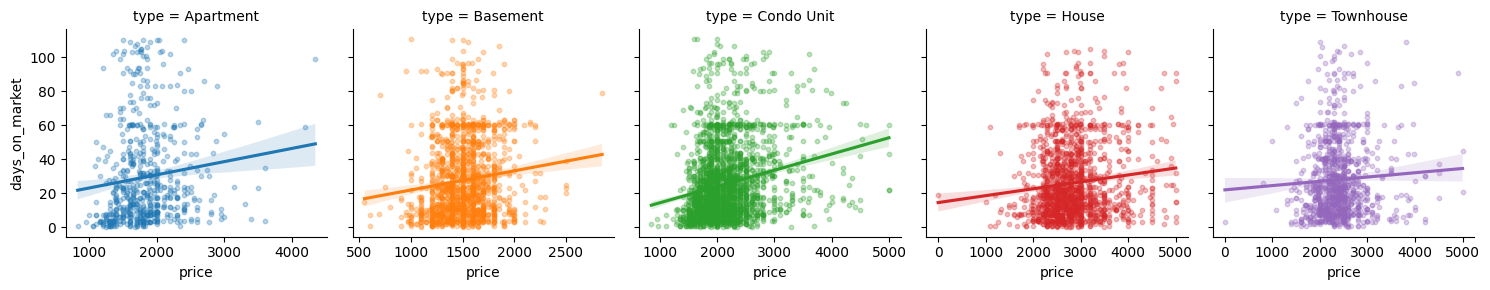

In [75]:
sns.lmplot(
            x='price',
            y='days_on_market',
            hue='type',
            col = 'type',
            data=inactive_filtered_listings,
            #aspect=1.5,
            legend=True,
            height=3,  # Height of the plot in inches
            facet_kws=dict(sharex=False, sharey=True),
            scatter_kws={'alpha': 0.3, 's': 10}  # Adjust alpha for transparency and s for size)
)
#plt.legend(loc='best')
plt.show()

- **Apartments** have a correlation of 0.11, indicating a very weak relationship between price and DOM.
- **Basements** show a correlation of 0.13, slightly stronger but still weak, suggesting minimal impact of price on how quickly they are rented.
- **Condo Units** display the highest correlation of 0.24, which is moderate and suggests a more noticeable but still not dominant effect of price on DOM.
- **Houses** have a correlation similar to **Basements** at 0.13, indicating a weak relationship.
- **Townhouses** show the weakest correlation at 0.06, suggesting that price has very little effect on DOM for this property type.
- The overall weak correlations suggest that while there might be a slight trend for more expensive properties to take longer to rent, the effect of price on rental speed is generally minimal across property types. Therefore, it is not necessarily true that cheaper rental listings are rented out significantly faster

### 8.11 How do the rental listings distribute in Calgary?

In [114]:
# Convert to a GeoDataFrame
gdf_rental_listings = gpd.GeoDataFrame(
    filtered_listings, 
    geometry=gpd.points_from_xy(filtered_listings.longitude, filtered_listings.latitude),
    crs="EPSG:4326"
)

In [115]:
gdf_rental_listings.columns

Index(['id', 'community', 'latitude', 'longitude', 'type', 'price', 'beds',
       'has_den', 'sq_feet', 'baths', 'cats', 'dogs', 'activation_date',
       'last_update', 'is_active', 'days_on_market', 'geometry'],
      dtype='object')

In [ ]:
from folium.plugins import FeatureGroupSubGroup
from folium.plugins import HeatMap
import branca

# Ensure that there are equal number of price steps and colors
price_steps = [0, 1499, 1999, 2499, 2999, 3999, gdf_rental_listings['price'].max() + 1]
colors = ['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837', '#004529']

assert len(price_steps) == len(colors) + 1, "There should be one more price step than colors"

# Create a function to map each price to a color based on the defined ranges
def get_color(price):
    for i, step in enumerate(price_steps):
        if price < step:
            return colors[i - 1]
    return colors[-1]  # If price exceeds the last step

# Create a base map
m = folium.Map(location=[51, -114], tiles="Cartodb Positron", zoom_start=10)

# Define the color scale
color_scale = branca.colormap.StepColormap(
    colors=colors,
    index=price_steps,
    vmin=gdf_rental_listings['price'].min(),
    vmax=gdf_rental_listings['price'].max(),
    caption='Price Scale'  # Caption for the color scale or legend
)

# Add the color scale to the map
m.add_child(color_scale)

# Prepare the data for the HeatMap (assuming price is already a number and not a string)
heat_data = [(row['latitude'], row['longitude'], row['price']) for index, row in gdf_rental_listings.iterrows()]

# Create a HeatMap layer
heatmap = HeatMap(heat_data, min_opacity=0.3, blur=50, name='Heat map')

# Add the HeatMap layer to the map
m.add_child(heatmap)

# Create a FeatureGroup for each price step
feature_groups = {
    'Up to 1499': FeatureGroupSubGroup(m, name='Up to 1499'),
    '1500-1999': FeatureGroupSubGroup(m, name='1500-1999'),
    '2000-2499': FeatureGroupSubGroup(m, name='2000-2499'),
    '2500-2999': FeatureGroupSubGroup(m, name='2500-2999'),
    '3000-3999': FeatureGroupSubGroup(m, name='3000-3999'),
    '4000+': FeatureGroupSubGroup(m, name='4000+')
}

# Add points to their respective feature group based on the custom price steps
for _, row in gdf_rental_listings.iterrows():
    tooltip_data = {col: str(row[col]) for col in gdf_rental_listings.columns if pd.notnull(row[col])}
    tooltip_text = '<br>'.join([f'{key}: {val}' for key, val in tooltip_data.items()])
    
    # Get the color for the price
    color = get_color(row['price'])
    
    # Create a Circle with the tooltip and color
    marker = folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=5,
        tooltip=tooltip_text,
        fill=True,
        color=color,
        fill_color=color,
        fill_opacity=0.7
    )
    
    # Determine the correct feature group for the price
    feature_group_label = ""
    for i, step in enumerate(price_steps):
        if row['price'] < step:
            feature_group_label = list(feature_groups.keys())[i - 1]
            break
    if not feature_group_label:
        feature_group_label = list(feature_groups.keys())[-1]
    
    # Add the marker to the correct feature group
    marker.add_to(feature_groups[feature_group_label])

# Add feature groups to the map
for fg in feature_groups.values():
    m.add_child(fg)

# Add LayerControl to the map
m.add_child(folium.LayerControl(collapsed=False))

# Display the map
m

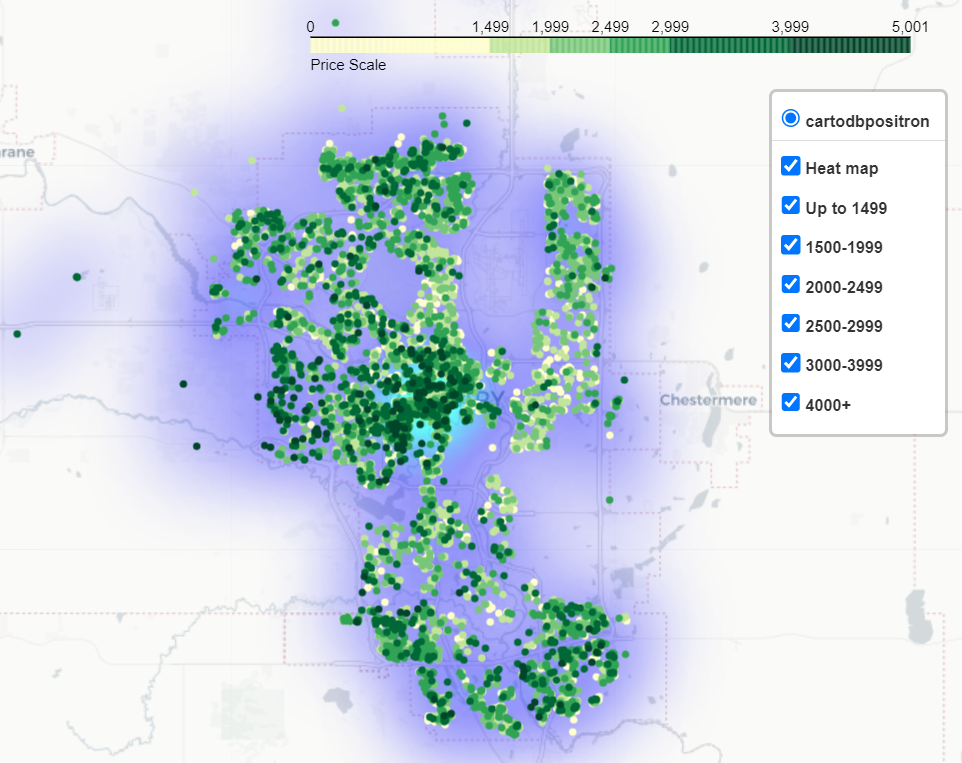

(saved as image to reduce the overall file size)

Rental listings are primarily concentrated in the Centre, which offers a wide price range, accommodating both budget-friendly and premium rental options. Conversely, rental listings outside the Centre are more evenly distributed, providing a consistent variety across different
price points.

## 9. Are rental listings being in the walk zones of better schools more expensive?

In [117]:
rental_listing_walk_zone = gpd.sjoin(gdf_rental_listings, walk_zones)

In [118]:
rental_listing_walk_zone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18717 entries, 0 to 11188
Data columns (total 78 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   id                                              18717 non-null  int64         
 1   community                                       18717 non-null  category      
 2   latitude                                        18717 non-null  float64       
 3   longitude                                       18717 non-null  float64       
 4   type                                            18717 non-null  category      
 5   price                                           18717 non-null  int64         
 6   beds                                            18717 non-null  float64       
 7   has_den                                         18717 non-null  bool          
 8   sq_feet                                    

-  the increase from 4940 to 5532 rows after the join suggests that 592 rental listings are counted more than once because they fall into the walk zones of multiple schools.

In [119]:
rental_listing_walk_zone.columns

Index(['id', 'community', 'latitude', 'longitude', 'type', 'price', 'beds',
       'has_den', 'sq_feet', 'baths', 'cats', 'dogs', 'activation_date',
       'last_update', 'is_active', 'days_on_market', 'geometry', 'index_right',
       'school_id', 'name_x', 'name_y', 'address', 'school_hour', 'grades',
       'ward', 'area', 'total_enrolment', 'programs_list', 'desc',
       'kindergarten_enrolment', 'grade_1_enrolment', 'grade_2_enrolment',
       'grade_3_enrolment', 'grade_4_enrolment', 'grade_5_enrolment',
       'grade_6_enrolment', 'grade_7_enrolment', 'grade_8_enrolment',
       'grade_9_enrolment', 'grade_10_enrolment', 'grade_11_enrolment',
       'grade_12_enrolment', 'school_rating', 'school_rank', 'school_group',
       'lottery_requirement', 'lottery_programs', 'early_childhood',
       'elementary', 'junior_high', 'senior_high', 'start_hour', 'end_hour',
       'classification', 'school_duration', '', 'Advanced Placement (AP)',
       'All Boys', 'All Girls', 'Alternativ

In [120]:
rental_listing_walk_zone.dropna(subset=['school_rating']).groupby(['type'],observed=True)[['school_rating','price']].corr()

school_rating     price
type                                             
Apartment  school_rating       1.000000  0.140878
           price               0.140878  1.000000
Basement   school_rating       1.000000  0.107890
           price               0.107890  1.000000
Condo Unit school_rating       1.000000  0.109980
           price               0.109980  1.000000
House      school_rating       1.000000  0.270226
           price               0.270226  1.000000
Townhouse  school_rating       1.000000  0.186969
           price               0.186969  1.000000

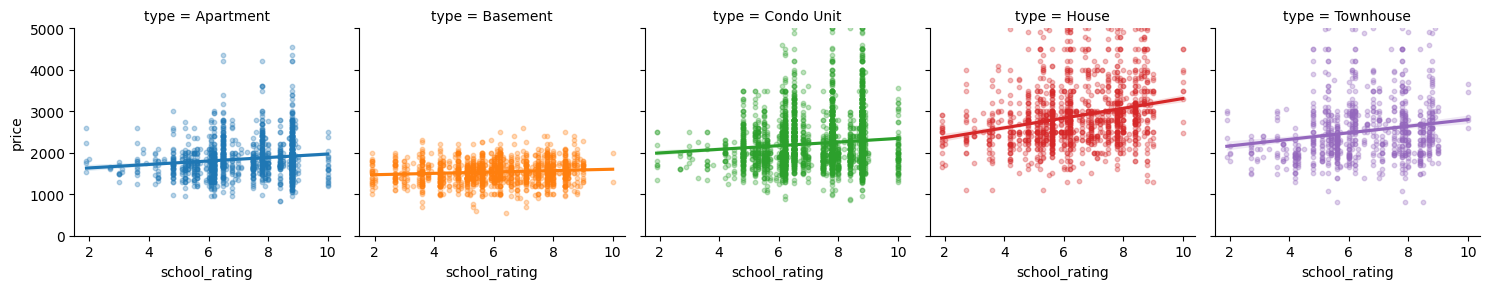

In [121]:
sns.lmplot(x='school_rating', y='price', 
           data=rental_listing_walk_zone.dropna(subset=['school_rating']), #drop null values for school_rating before plotting
           hue='type', 
           col='type',
           #aspect=1.5, 
           fit_reg=True, 
           legend=True,
           height=3,  # Height of the plot in inches
            facet_kws=dict(sharex=False, sharey=True,ylim=(0, 5000)),
            scatter_kws={'alpha': 0.3, 's': 10},  # Adjust alpha for transparency and s for size)
            )
#plt.title('Price vs School Rating')
plt.show()

- The correlations are all positive, indicating that generally, higher school ratings are associated with higher rental prices, although the strength of this relationship varies by property type.
- **Apartments**: Correlation of 0.15, suggesting a weak but positive relationship between school ratings and rental prices.
- **Basements**: Slightly stronger correlation of 0.18, indicating a modest relationship where higher school ratings may influence higher rental prices.
- **Condo Units**: Weakest correlation of 0.07, showing that school ratings have a minimal impact on rental prices for condos.
- **Houses**: Highest correlation of 0.25, suggesting a more substantial positive impact of school ratings on rental prices compared to other property types.
- **Townhouses**: Correlation of 0.20, which is moderately positive, indicating that school ratings have a noticeable but not overwhelming impact on rental prices.
- While positive correlations across the board suggest that higher school ratings can contribute to higher rental prices, the strength of this relationship varies significantly across different property types. **Houses** show the strongest correlation, indicating that school ratings are a more critical factor in determining rental prices for this property type. Conversely, condos show the least correlation, suggesting other factors may play a more dominant role in pricing.

### 9.1 Does rental listings being in the walk zones of schools offering special programs affect the price?

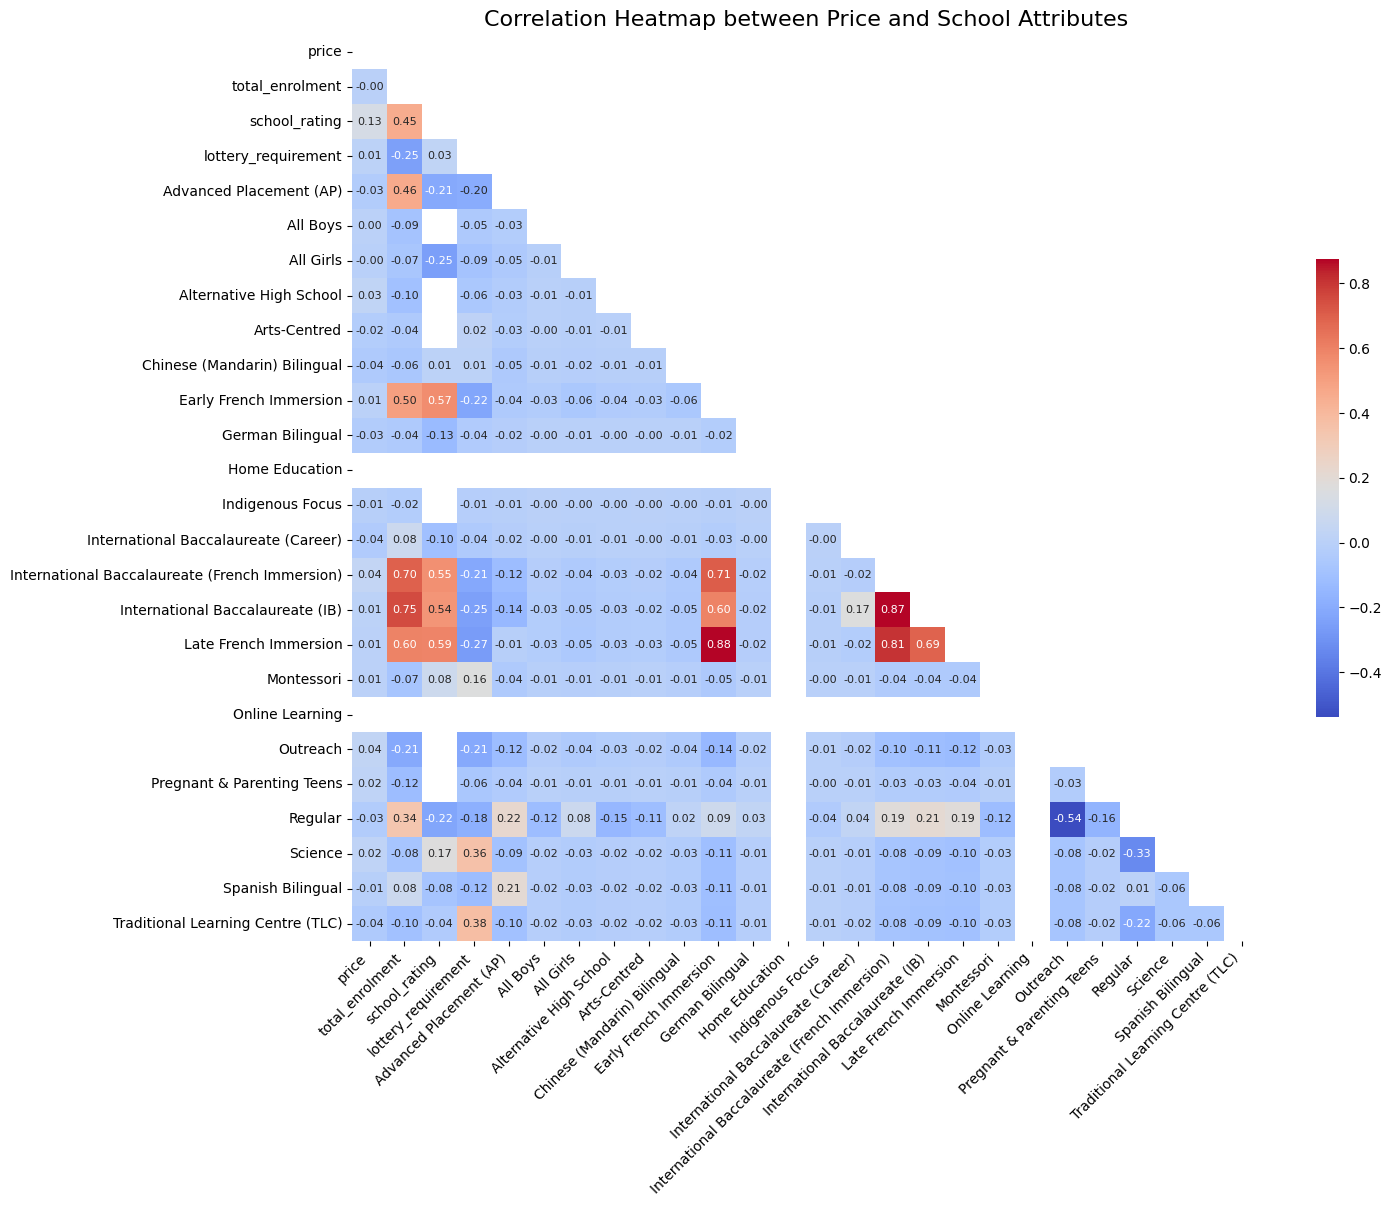

In [122]:
school_attributes = [
    'price', 'total_enrolment', 'school_rating','lottery_requirement','Advanced Placement (AP)', 'All Boys',
       'All Girls', 'Alternative High School', 'Arts-Centred',
       'Chinese (Mandarin) Bilingual', 'Early French Immersion',
       'German Bilingual', 'Home Education', 'Indigenous Focus',
       'International Baccalaureate (Career)',
       'International Baccalaureate (French Immersion)',
       'International Baccalaureate (IB)', 'Late French Immersion',
       'Montessori', 'Online Learning', 'Outreach',
       'Pregnant & Parenting Teens', 'Regular', 'Science', 'Spanish Bilingual',
       'Traditional Learning Centre (TLC)'
]

correlation_matrix = rental_listing_walk_zone[school_attributes].corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12)) # Increase figure size if needed

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            annot_kws={"size": 8}, square=True, cbar_kws={"shrink": .5})

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels
plt.yticks(rotation=0)

# Improve layout to avoid tight layout issues
plt.tight_layout()

# Add title
plt.title('Correlation Heatmap between Price and School Attributes', size=16)

# Show the plot
plt.show()

                         Advanced Placement (AP)    price
Advanced Placement (AP)                  1.00000 -0.03222
price                                   -0.03222  1.00000
          All Boys     price
All Boys  1.000000  0.003855
price     0.003855  1.000000
           All Girls     price
All Girls   1.000000 -0.003429
price      -0.003429  1.000000
                         Alternative High School     price
Alternative High School                 1.000000  0.025964
price                                   0.025964  1.000000
              Arts-Centred     price
Arts-Centred      1.000000 -0.024127
price            -0.024127  1.000000
                              Chinese (Mandarin) Bilingual     price
Chinese (Mandarin) Bilingual                      1.000000 -0.043696
price                                            -0.043696  1.000000
                        Early French Immersion     price
Early French Immersion                1.000000  0.007272
price                                

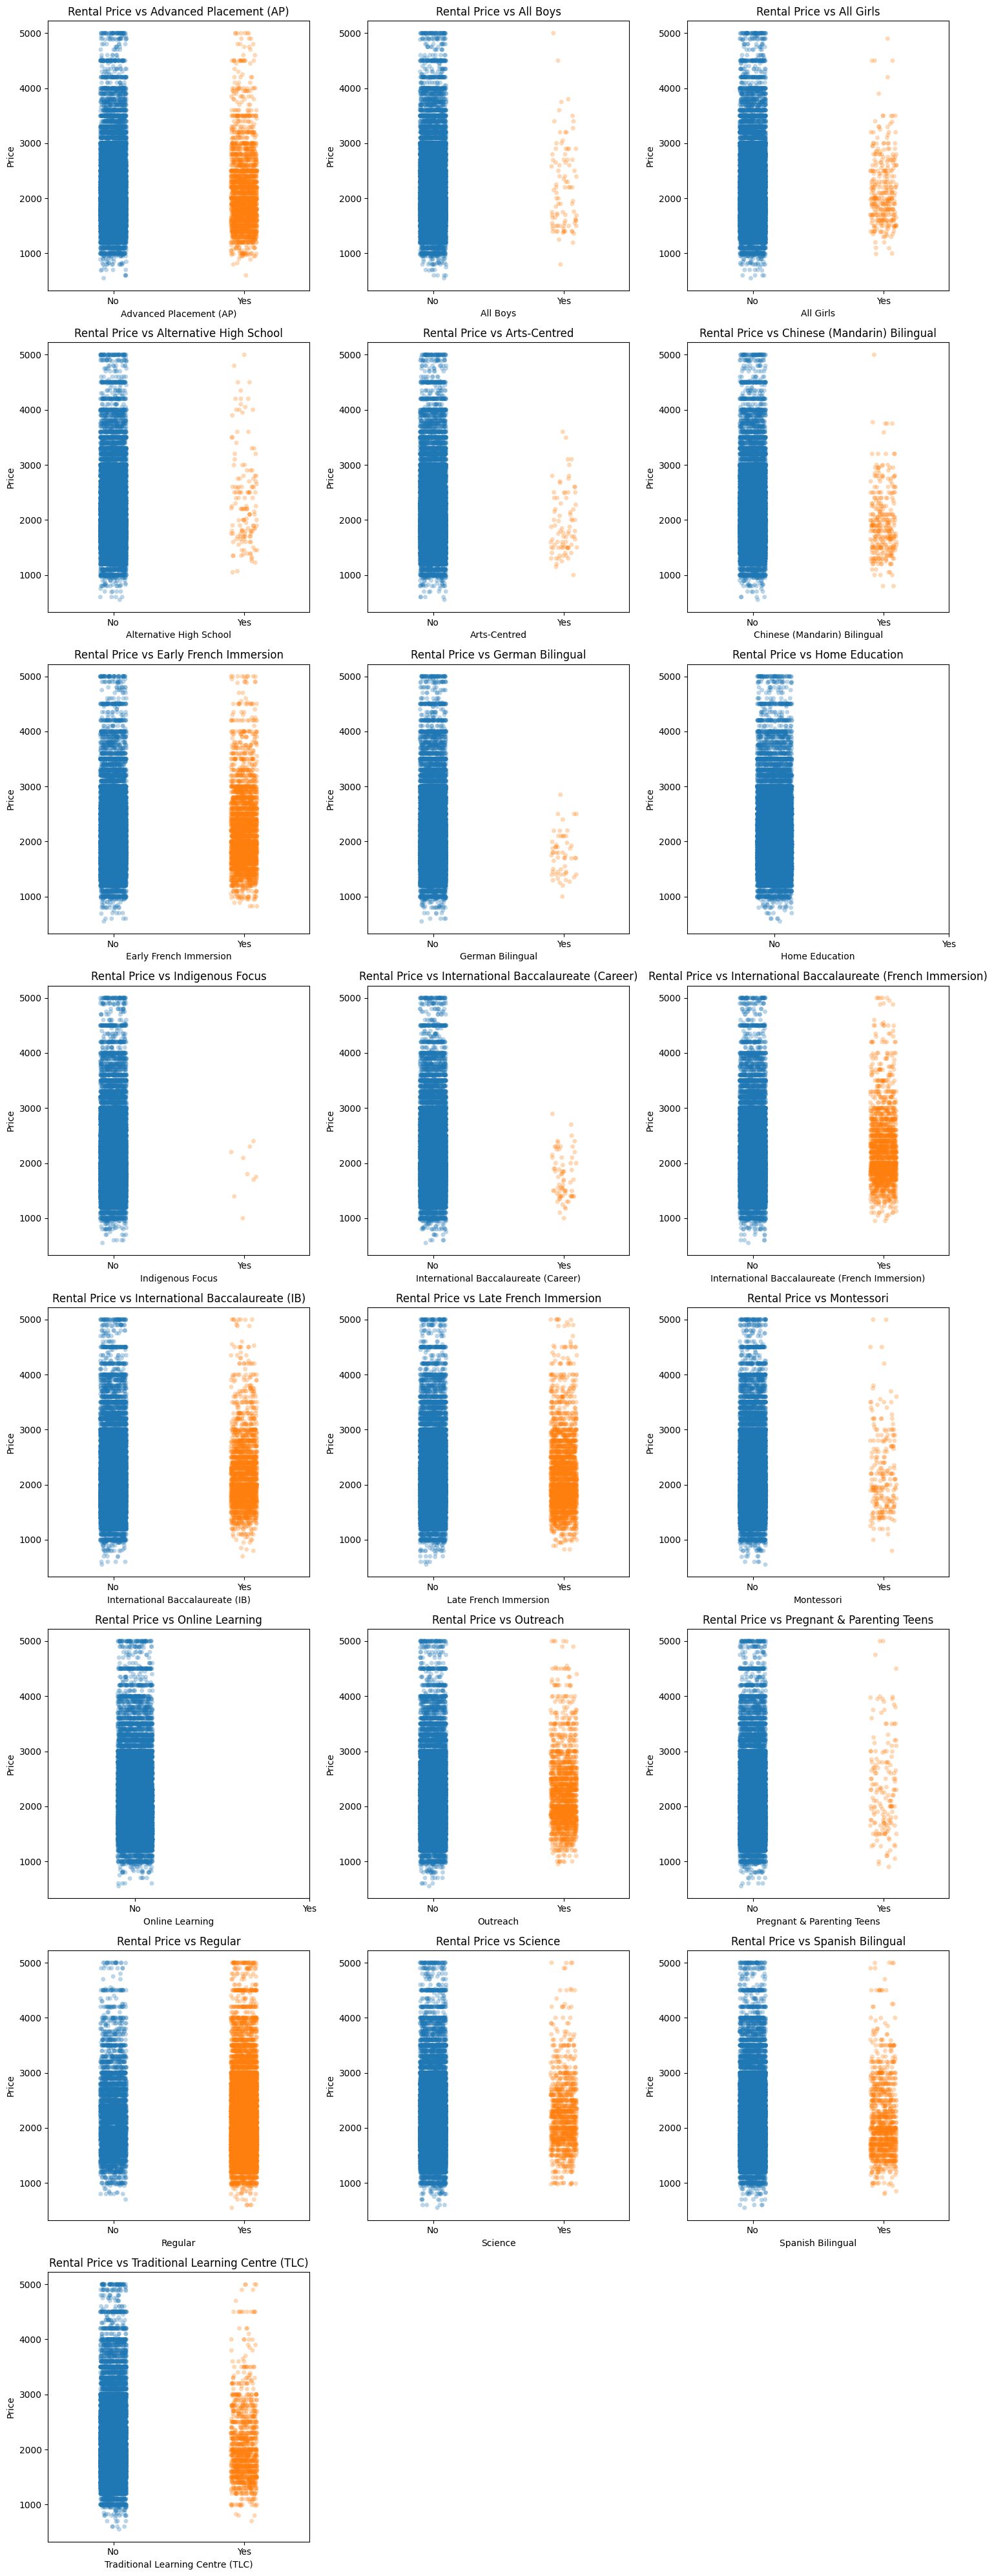

In [123]:
# List of boolean columns to plot against 'price'
boolean_columns = ['Advanced Placement (AP)', 'All Boys', 'All Girls', 'Alternative High School',
                   'Arts-Centred', 'Chinese (Mandarin) Bilingual', 'Early French Immersion',
                   'German Bilingual', 'Home Education', 'Indigenous Focus',
                   'International Baccalaureate (Career)',
                   'International Baccalaureate (French Immersion)',
                   'International Baccalaureate (IB)', 'Late French Immersion',
                   'Montessori', 'Online Learning', 'Outreach',
                   'Pregnant & Parenting Teens', 'Regular', 'Science', 'Spanish Bilingual',
                   'Traditional Learning Centre (TLC)']

# Set up the matplotlib figure
num_plots = len(boolean_columns)
num_cols = 3 # You can choose another number of columns based on your preference
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the required number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
fig.tight_layout(pad=5.0)  # Add space between plots

# Create a scatter plot for each boolean attribute
for i, col in enumerate(boolean_columns):
    # Determine the position of the current plot
    row = i // num_cols
    col_idx = i % num_cols
    
    #print out the metadata
    
    print(rental_listing_walk_zone[[col,'price']].corr())
    # Create the scatter plot with jitter
    sns.stripplot(ax=axes[row, col_idx],
                  x=rental_listing_walk_zone[col],
                  y=rental_listing_walk_zone['price'],
                  jitter=True, #for easier comparison
                  alpha = 0.3,
                  hue = rental_listing_walk_zone[col],
                  legend = False)
    
    # Set the title for the current plot
    axes[row, col_idx].set_title(f'Rental Price vs {col}')
    
    # Improve plot appearance
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Price')
    
    # If you want to only show '0' and '1' in the xticks
    axes[row, col_idx].set_xticks([0, 1])
    axes[row, col_idx].set_xticklabels(['No', 'Yes'])

# Hide any unused subplots if the number of boolean attributes is not a multiple of `num_cols`
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

# Adjust the layout
plt.tight_layout()

# Show the giant subplot with all the scatter plots
plt.show()

- Overall, the correlations between specialized educational programs and rental prices are very weak, suggesting that these program offerings are not major factors that renters consider when assessing property values. The presence of a particular educational program rarely sways rental prices significantly.

## 10. Does historic community crime count affect the rental price?

In [124]:
community_crime['crime_count'].describe()

count      297.00000
mean       776.03367
std       1007.90843
min          1.00000
25%        150.00000
50%        510.00000
75%       1138.00000
max      11188.00000
Name: crime_count, dtype: float64

<Axes: xlabel='crime_count'>

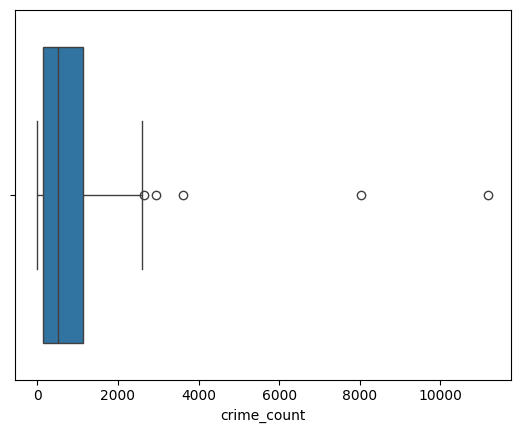

In [125]:
sns.boxplot(x=community_crime['crime_count'],)

### Distribution of 'Crime Count' Across Communities

- **Count**: Data encompasses 297 communities.
- **Mean**: Average crime count is approximately 776 incidents per community.
- **Standard Deviation**: High standard deviation of around 1008, indicating significant variation in crime counts between communities.
- **Minimum**: The community with the least crime reports a single incident.
- **Quartiles**:
  - **25%** of communities have 150 incidents or fewer.
  - The **median** (50%) crime count is 510, suggesting that half of the communities have crime counts below this number.
  - **75%** of communities experience 1138 incidents or fewer, which implies that the remaining 25% have higher crime counts, potentially skewing the average.
- **Maximum**: The community with the most crime reports as many as 11188 incidents (Beltline), which is substantially higher than the mean, indicating the presence of outliers with extremely high crime counts.

In [126]:
community_crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   row_id          297 non-null    int64   
 1   crime_count     297 non-null    float64 
 2   class           297 non-null    object  
 3   class_code      297 non-null    float64 
 4   comm_code       297 non-null    object  
 5   name            297 non-null    object  
 6   sector          297 non-null    object  
 7   srg             242 non-null    object  
 8   comm_structure  295 non-null    object  
 9   multipolygon    297 non-null    object  
 10  geometry        297 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 25.6+ KB


In [127]:
community_crime.head()

row_id  crime_count        class  class_code comm_code  \
0       1      11188.0  Residential         1.0       BLN   
1       2       8028.0  Residential         1.0       DNC   
2       3       3611.0  Residential         1.0       FLN   
3       4       2942.0  Residential         1.0       BOW   
4       5       2650.0   Industrial         2.0       MNI   

                       name     sector          srg comm_structure  \
0                  beltline     CENTRE  ESTABLISHED    CENTRE CITY   
1  downtown commercial core     CENTRE  ESTABLISHED    CENTRE CITY   
2               forest lawn       EAST  ESTABLISHED          1950s   
3                   bowness  NORTHWEST  ESTABLISHED          1950s   
4     manchester industrial     CENTRE         None     EMPLOYMENT   

                                        multipolygon  \
0  MULTIPOLYGON (((-114.0837958 51.0445433, -114....   
1  MULTIPOLYGON (((-114.0831698 51.0504195, -114....   
2  MULTIPOLYGON (((-113.9582069 51.0451914, -113....   
3  MULTIPOLYGON (((-114.2278921 51.0988372, -114....   
4  MULTIPOLYGON (((-114.0715684 51.0013825, -114....   

                                            geometry  
0  MULTIPOLYGON (((-114.08380 51.04454, -114.0887...  
1  MULTIPOLYGON (((-114.08317 51.05042, -114.0831...  
2  MULTIPOLYGON (((-113.95821 51.04519, -113.9583...  
3  MULTIPOLYGON (((-114.22789 51.09884, -114.2279...  
4  MULTIPOLYGON (((-114.07157 51.00138, -114.0715...

Now let's visualize the `class` attribute across different communities.

In [ ]:
import folium
import seaborn as sns
from folium.features import GeoJsonTooltip

# Create a base map
m = folium.Map(location=[51, -114], tiles="Cartodb Positron", zoom_start=10)

# Function to create a folium layer from a GeoDataFrame based on a classification field
def create_classification_layer(gdf, classification_field, map_object):
    # Create a dictionary to store folium LayerControl items
    layer_dict = {}
    
    # Get a list of unique classes
    unique_classes = gdf[classification_field].unique()
    
    # Generate a color palette with Seaborn
    palette = sns.color_palette("hsv", len(unique_classes)).as_hex()
    
    # Get all column names except the geometry column
    all_columns = gdf.drop(columns=['geometry','multipolygon']).columns.tolist()
    
    for classification, color in zip(unique_classes, palette):
        # Filter the GeoDataFrame for each class
        class_gdf = gdf[gdf[classification_field] == classification]
        
        # Create a GeoJson layer for each class
        layer = folium.GeoJson(
            class_gdf.to_json(),
            name=classification,
            style_function=lambda feature, color=color: {
                'fillColor': color,
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            },
            tooltip=GeoJsonTooltip(
                fields=all_columns,
                aliases=[col.replace('_', ' ').title() for col in all_columns],
                localize=True
            )
        )
        
        # Add the layer to the map
        layer.add_to(map_object)
        
        # Add the layer to the dictionary
        layer_dict[classification] = layer
    
    return layer_dict

# Create the 'class' layers and add them to the map
class_layers = create_classification_layer(community_crime, 'class', m)

# Add layer control to the map to toggle layers
layer_control = folium.LayerControl(collapsed=False).add_to(m)

# Display the map
m

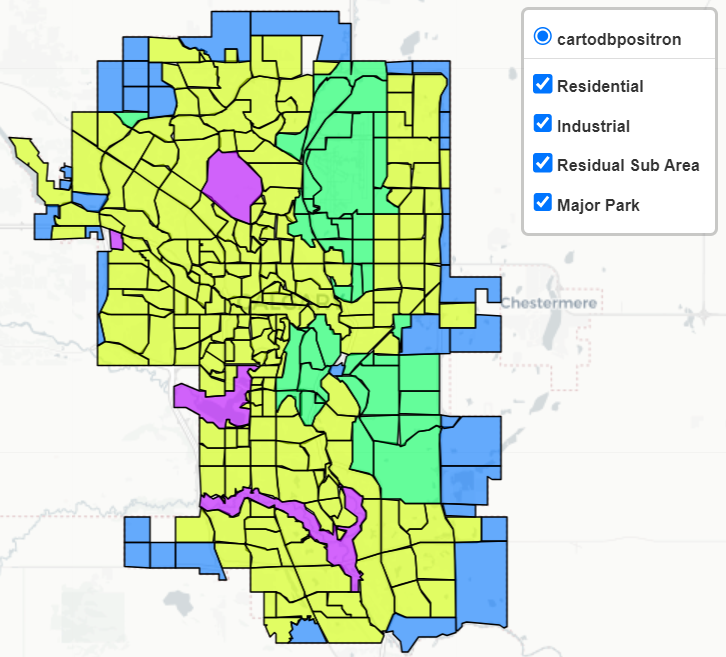

(saved as image to reduce the overall file size)

The majority of the city's communities are residential areas. The industrial areas are concentrated on the northeast, east and southeast of the city. There are mainly 3 major parks situated in the south and northwest of the city. At the peripheral of the city, there are some resitential sub area.

Now let's visualize the `sector` attribute across different communities.

In [ ]:
# Create a base map
m = folium.Map(location=[51, -114], tiles="Cartodb Positron", zoom_start=10)

# Create the 'sector' layers and add them to the map
class_layers = create_classification_layer(community_crime, 'sector', m)

# Add layer control to the map to toggle layers
layer_control = folium.LayerControl(collapsed=False).add_to(m)

# Display the map as 'm' in an interactive environment like Jupyter Notebook
m

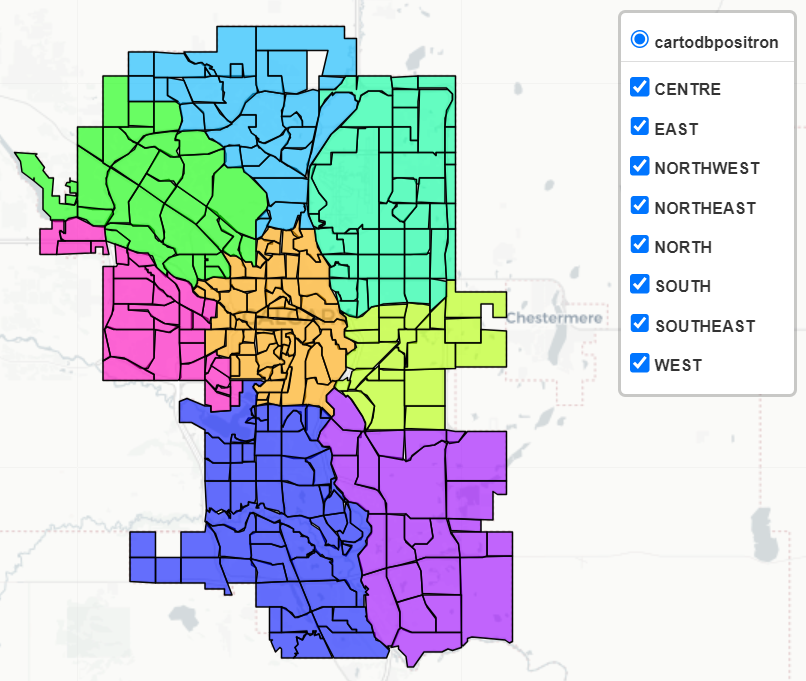

(saved as image to reduce the overall file size)

It has been noted that from the central sector, sectors radiate outward in each cardinal direction (East, South, West, North) and in three of the intercardinal directions (Northeast, Northwest, and Southeast), with the exception of the Southwest direction, which is absent.

Now let's visualize the `comm_structure` attribute across different communities.

In [ ]:
# Create a base map
m = folium.Map(location=[51, -114], tiles="Cartodb Positron", zoom_start=10)

# Create the 'comm_structure' layers and add them to the map
class_layers = create_classification_layer(community_crime.dropna(subset = 'comm_structure'), 'comm_structure', m)

# Add layer control to the map to toggle layers
layer_control = folium.LayerControl(collapsed=False).add_to(m)

# Display the map as 'm' in an interactive environment like Jupyter Notebook
m

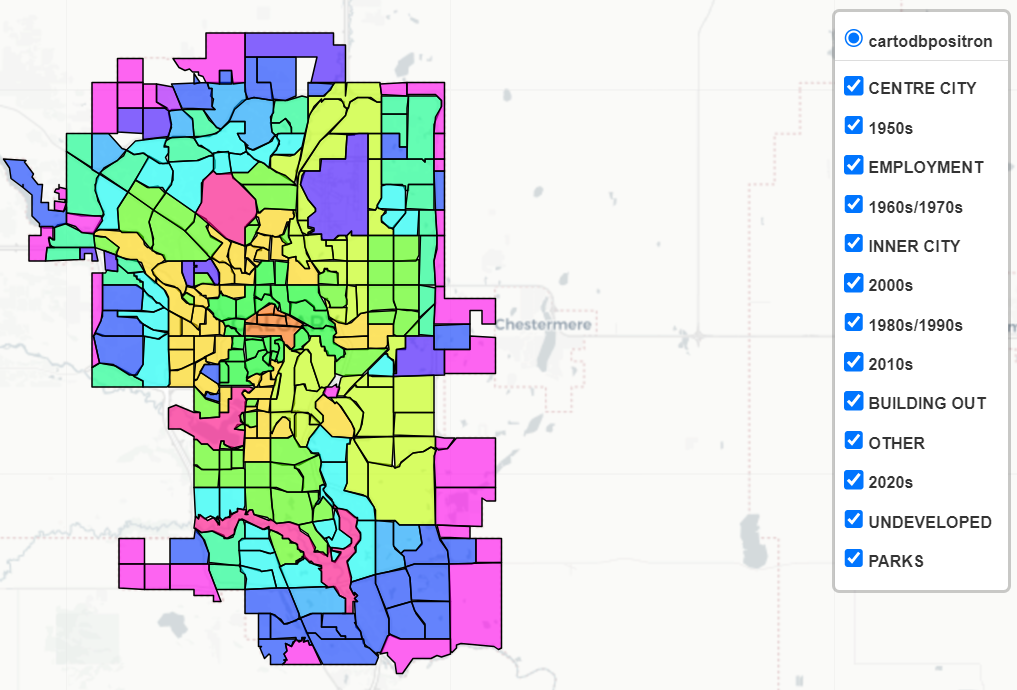

(saved as image to reduce the overall file size)

The community structure is organized as follows: the downtown area serves as the central city, expanding outward into the inner city. This expansion continues into residential areas, which are categorized by decades: 1950s, 1960s, 1970s, 1980s, 1990s, 2000s, 2010s, and 2020s. Observing the trends and patterns in development, it is evident that the current focus of development is primarily towards the south and southeast of the city.

Now let's visualize the `srg` attribute across different communities.

In [ ]:
# Create a base map
m = folium.Map(location=[51, -114], tiles="Cartodb Positron", zoom_start=10)

# Create the 'srg' layers and add them to the map
class_layers = create_classification_layer(community_crime.dropna(subset = 'srg'), 'srg', m)

# Add layer control to the map to toggle layers
layer_control = folium.LayerControl(collapsed=False).add_to(m)

# Display the map as 'm' in an interactive environment like Jupyter Notebook
m

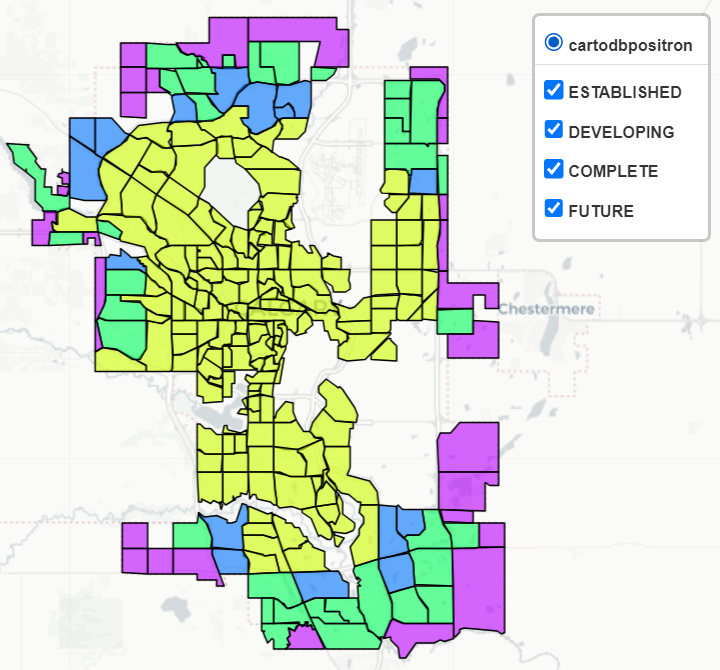

(saved as image to reduce the overall file size)

Similar to the `comm_structure`, the `srg` indicates that the majority of the development, including the areas designated as "future" (which may refer to those planned for upcoming development), is concentrated in the southern and southeastern sectors.

In [132]:
# Convert to a GeoDataFrame
gdf_all_rental_listings = gpd.GeoDataFrame(
    filtered_listings, 
    geometry=gpd.points_from_xy(filtered_listings.longitude, filtered_listings.latitude),
    crs="EPSG:4326"
)

In [133]:
rental_listing_crime = gpd.sjoin(gdf_all_rental_listings,community_crime,how='inner')

In [134]:
rental_listing_crime.columns

Index(['id', 'community', 'latitude', 'longitude', 'type', 'price', 'beds',
       'has_den', 'sq_feet', 'baths', 'cats', 'dogs', 'activation_date',
       'last_update', 'is_active', 'days_on_market', 'geometry', 'index_right',
       'row_id', 'crime_count', 'class', 'class_code', 'comm_code', 'name',
       'sector', 'srg', 'comm_structure', 'multipolygon'],
      dtype='object')

In [135]:
rental_listing_crime.groupby('type',observed=True)[['crime_count','price']].corr()

crime_count     price
type                                         
Apartment  crime_count     1.000000  0.131428
           price           0.131428  1.000000
Basement   crime_count     1.000000 -0.027111
           price          -0.027111  1.000000
Condo Unit crime_count     1.000000  0.153585
           price           0.153585  1.000000
House      crime_count     1.000000 -0.125395
           price          -0.125395  1.000000
Townhouse  crime_count     1.000000 -0.070803
           price          -0.070803  1.000000

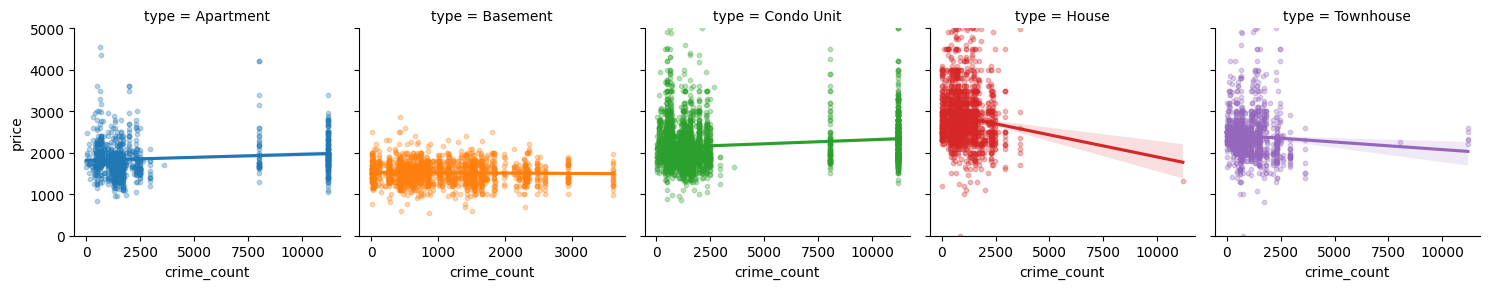

In [136]:
sns.lmplot(x='crime_count', y='price', 
           data=rental_listing_crime,
           col='type', 
           hue='type',
           fit_reg=True, 
           legend=False,
           height=3,  
            facet_kws=dict(sharex=False, sharey=True,ylim=(0, 5000)),
            scatter_kws={'alpha': 0.3, 's': 10},  # Adjust alpha for transparency and s for size)
            )
#plt.title('Price vs School Rating')
plt.show()

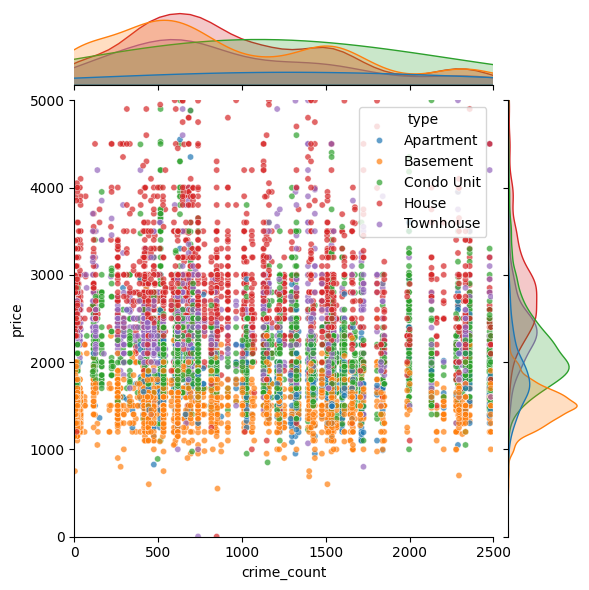

In [137]:
sns.jointplot(x='crime_count', y='price', 
           data=rental_listing_crime,
           hue='type', 
            alpha= 0.7, s= 20, 
            xlim=(0,2500),ylim=(0,5000)
            )


- The correlation between crime counts in the community and rental prices across different property types is generally weak. Positive correlations are seen with apartments and condo units, possibly due to other factors that also affect prices, such as location desirability or amenities. The slight negative correlations for basement units, houses, and townhouses suggest that rental prices for these property types might be less influenced by community crime counts.

## Sector vs rental listings

In [138]:
rental_listing_crime.columns

Index(['id', 'community', 'latitude', 'longitude', 'type', 'price', 'beds',
       'has_den', 'sq_feet', 'baths', 'cats', 'dogs', 'activation_date',
       'last_update', 'is_active', 'days_on_market', 'geometry', 'index_right',
       'row_id', 'crime_count', 'class', 'class_code', 'comm_code', 'name',
       'sector', 'srg', 'comm_structure', 'multipolygon'],
      dtype='object')

In [139]:
rental_listing_crime.head(3)

id  community   latitude   longitude        type  price  beds  has_den  \
0     456  Sunnyside  51.058014 -114.075440   Apartment   1525   1.0    False   
58   9335  Sunnyside  51.055869 -114.083876  Condo Unit   1895   1.0    False   
81  13944  Sunnyside  51.056965 -114.077260   Apartment   1795   2.0    False   

    sq_feet  baths  ...  row_id  crime_count        class class_code  \
0     650.0    1.0  ...      59       1319.0  Residential        1.0   
58    600.0    1.0  ...      59       1319.0  Residential        1.0   
81    850.0    1.0  ...      59       1319.0  Residential        1.0   

    comm_code       name  sector          srg  comm_structure  \
0         SSD  sunnyside  CENTRE  ESTABLISHED      INNER CITY   
58        SSD  sunnyside  CENTRE  ESTABLISHED      INNER CITY   
81        SSD  sunnyside  CENTRE  ESTABLISHED      INNER CITY   

                                         multipolygon  
0   MULTIPOLYGON (((-114.0669838 51.0587428, -114....  
58  MULTIPOLYGON (((-114.0669838 51.0587428, -114....  
81  MULTIPOLYGON (((-114.0669838 51.0587428, -114....  

[3 rows x 28 columns]

In [140]:
rental_listing_crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 9106 entries, 0 to 11105
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               9106 non-null   int64         
 1   community        9106 non-null   category      
 2   latitude         9106 non-null   float64       
 3   longitude        9106 non-null   float64       
 4   type             9106 non-null   category      
 5   price            9106 non-null   int64         
 6   beds             9106 non-null   float64       
 7   has_den          9106 non-null   bool          
 8   sq_feet          9106 non-null   float64       
 9   baths            9106 non-null   float64       
 10  cats             9106 non-null   bool          
 11  dogs             9106 non-null   bool          
 12  activation_date  9106 non-null   datetime64[ns]
 13  last_update      9106 non-null   datetime64[ns]
 14  is_active        9106 non-null   boo

In [141]:
rental_listing_crime['class'].value_counts()

class
Residential          9085
Residual Sub Area      12
Industrial              7
Major Park              2
Name: count, dtype: int64

In [142]:
rental_listing_crime['sector'].value_counts()

sector
CENTRE       3112
NORTH        1419
SOUTH        1163
SOUTHEAST    1042
NORTHWEST     831
NORTHEAST     744
WEST          578
EAST          217
Name: count, dtype: int64

In [143]:
rental_listing_crime['comm_structure'].value_counts()

comm_structure
BUILDING OUT    2051
INNER CITY      1318
CENTRE CITY     1284
1950s           1121
2000s           1039
1960s/1970s      864
1980s/1990s      674
2010s            575
2020s             70
OTHER             39
EMPLOYMENT        11
UNDEVELOPED        9
PARKS              2
Name: count, dtype: int64

In [144]:
rental_listing_crime['srg'].value_counts()

srg
ESTABLISHED    5476
DEVELOPING     2520
COMPLETE       1086
FUTURE           11
Name: count, dtype: int64

In [145]:
# Convert 'community' and 'type' to categorical columns
rental_listing_crime['class'] = rental_listing_crime['class'].astype('category')
rental_listing_crime['sector'] = rental_listing_crime['sector'].astype('category')
rental_listing_crime['comm_structure'] = rental_listing_crime['comm_structure'].astype('category')
rental_listing_crime['srg'] = rental_listing_crime['srg'].astype('category')


In [146]:
rental_listing_crime.groupby('sector',observed = True)['price'].describe()

count         mean         std     min      25%     50%     75%  \
sector                                                                        
CENTRE     3112.0  2240.167416  688.735245   800.0  1774.75  2100.0  2600.0   
EAST        217.0  1924.557604  531.929043   975.0  1500.00  1875.0  2225.0   
NORTH      1419.0  2100.767442  596.326963     0.0  1600.00  2050.0  2500.0   
NORTHEAST   744.0  1961.747312  504.736994  1000.0  1500.00  1980.0  2300.0   
NORTHWEST   831.0  2205.987966  667.653526   825.0  1700.00  2050.0  2700.0   
SOUTH      1163.0  2169.442820  634.064435   600.0  1675.00  2100.0  2550.0   
SOUTHEAST  1042.0  2137.035509  626.347775   550.0  1650.00  2100.0  2500.0   
WEST        578.0  2471.254325  803.354809  1075.0  1800.00  2397.5  2900.0   

              max  
sector             
CENTRE     5000.0  
EAST       4995.0  
NORTH      4300.0  
NORTHEAST  4000.0  
NORTHWEST  5000.0  
SOUTH      4999.0  
SOUTHEAST  4995.0  
WEST       5000.0

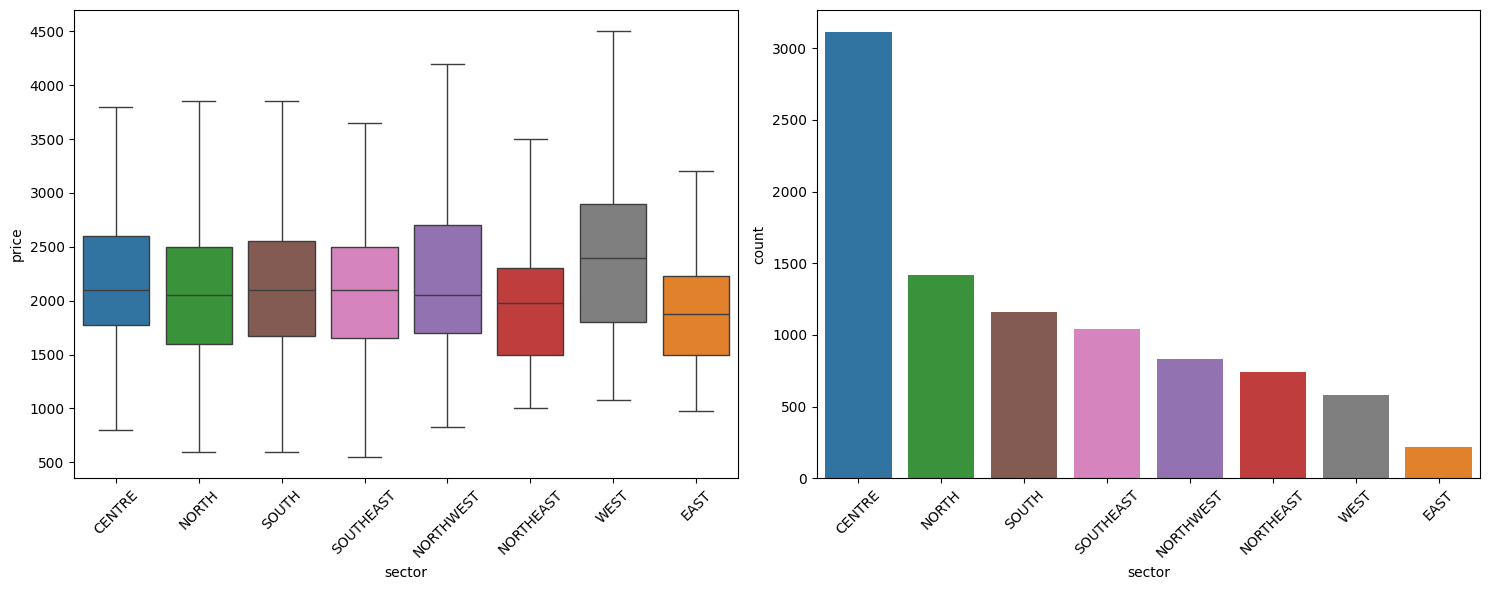

In [147]:
# Determine the order for plotting based on the 'sector' value counts
order = rental_listing_crime['sector'].value_counts().sort_values(ascending=False).index

# Create a figure and two axes for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Boxplot on the left (axs[0])
sns.boxplot(x='sector',
            y='price',
            data=rental_listing_crime,
            showfliers=False,
            hue='sector',
            ax=axs[0],
            order=order)  # Order the boxplot
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Countplot on the right (axs[1])
sns.countplot(x='sector',
              data=rental_listing_crime,
              hue='sector',
              ax=axs[1],
              order=order)  # Order the countplot
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

### Insights

- The **WEST sector** boasts the highest average rental price, indicating a prevalence of upscale properties.
- A diverse mix of housing is evident in the **CENTRE sector**, with a wide price range suggesting both economical and luxury accommodations.
- Median rental prices across sectors generally converge around the $2,000 mark, with the **CENTRE** and **WEST** sectors showing slightly elevated medians.
- The notably low minimum values in the **NORTH** and **NORTHEAST** sectors may point to data irregularities. These are removed from the plots.
- The **CENTRE sector**'s maximum rental price significantly exceeds those of other sectors, hinting at exclusive real estate options that could affect average rent calculations.

In [148]:
rental_listing_crime.groupby('comm_structure',observed = True)['price'].describe()

count         mean          std     min      25%     50%  \
comm_structure                                                              
1950s           1121.0  2080.115968   707.811198   800.0  1599.00  1895.0   
1960s/1970s      864.0  2009.648148   608.467540   690.0  1600.00  1900.0   
1980s/1990s      674.0  2321.097923   679.150925   550.0  1800.00  2295.0   
2000s           1039.0  2169.594803   600.476534   900.0  1700.00  2190.0   
2010s            575.0  2233.226087   616.228105     0.0  1797.50  2200.0   
2020s             70.0  2149.414286   562.151367  1250.0  1600.00  2200.0   
BUILDING OUT    2051.0  2152.689420   653.438615     1.0  1612.50  2100.0   
CENTRE CITY     1284.0  2335.740654   593.217935  1000.0  1938.75  2243.0   
EMPLOYMENT        11.0  2104.636364   692.216335  1200.0  1722.50  1800.0   
INNER CITY      1318.0  2182.146434   730.836152   900.0  1695.00  1999.0   
OTHER             39.0  2413.641026   630.858583  1450.0  1850.00  2295.0   
PARKS              2.0  1875.000000   954.594155  1200.0  1537.50  1875.0   
UNDEVELOPED        9.0  1972.222222  1011.839634  1150.0  1400.00  1450.0   

                    75%     max  
comm_structure                   
1950s           2500.00  5000.0  
1960s/1970s     2300.00  5000.0  
1980s/1990s     2800.00  5000.0  
2000s           2500.00  4800.0  
2010s           2600.00  4300.0  
2020s           2500.00  3600.0  
BUILDING OUT    2500.00  4995.0  
CENTRE CITY     2600.00  5000.0  
EMPLOYMENT      2500.00  3586.0  
INNER CITY      2598.75  5000.0  
OTHER           2800.00  3950.0  
PARKS           2212.50  2550.0  
UNDEVELOPED     2600.00  4050.0

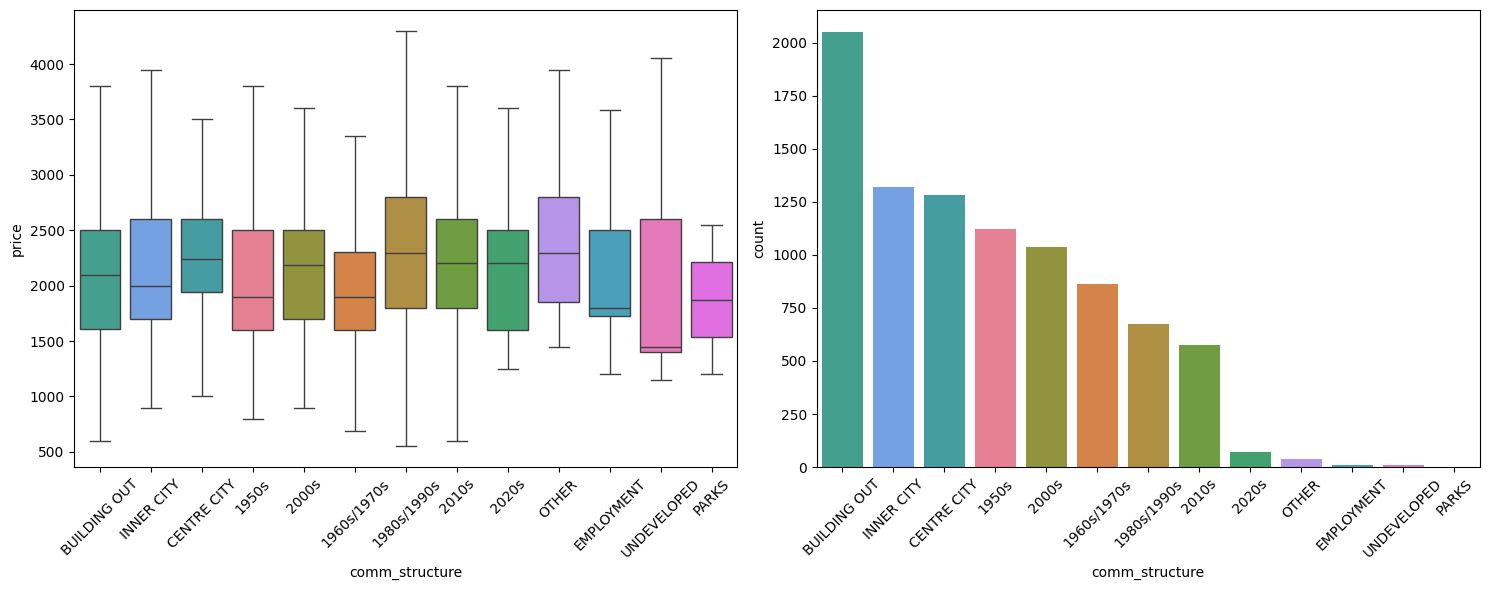

In [149]:
# Determine the order for plotting based on the 'type' value counts
order = rental_listing_crime['comm_structure'].value_counts().sort_values(ascending=False).index

# Create a figure and two axes for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Boxplot on the left (axs[0])
sns.boxplot(x='comm_structure',
            y='price',
            data=rental_listing_crime,
            showfliers=False,
            hue='comm_structure',
            legend=False,
            ax=axs[0],
            order=order)  # Order the boxplot
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Countplot on the right (axs[1])
sns.countplot(x='comm_structure',
              data=rental_listing_crime,
              hue='comm_structure',
              legend=False,
              ax=axs[1],
              order=order)  # Order the countplot
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

Community Structure: Used to identify life-cycle patterns and to develop the demographic model of Calgary. Where a decade is listed at least 51% of a community's peak population must be in place by the end of the decade it is assigned to

### Insights on Rental Prices by Community Structure

- The **CENTRE CITY** sector stands out with a relatively high mean rental price of $2,407.80, aligning with the expected premium for central locations.
- **INNER CITY** rents are also relatively high on average ($2,238.80), which could be due to proximity to city amenities and attractions.
- Rental properties from the **2020s** show less variability in prices (standard deviation of $624.32) and a tighter price range ($1,000 to $3,600), possibly due to standardized pricing in newer developments.
- Properties from the **1980s/1990s** have the highest average rent at $2,316.46, likely reflecting renovations or desirable features from that era.
- The **1960s/1970s** community structure has a notably high maximum rent ($14,995), which could be an outlier or indicative of a highly unique or updated property. Outliers are removed from the plot.
- The **1950s** structures show considerable affordability with a mean rent of $2,087.82, possibly reflecting the age and potential for outdated features of these properties.
- As expected, the **PARKS**, **EMPLOYMENT** and **UNDEVELOPED** categories have extremely limited data (1, 8 and 4 entries, respectively), making it difficult to draw meaningful conclusions about these sectors.

In [150]:
rental_listing_crime.groupby('srg',observed = True)['price'].describe()

count         mean          std     min     25%     50%     75%  \
srg                                                                             
COMPLETE     1086.0  2259.985267   615.791896     0.0  1800.0  2200.0  2637.5   
DEVELOPING   2520.0  2118.401984   630.689586     1.0  1600.0  2100.0  2500.0   
ESTABLISHED  5476.0  2190.277940   678.644939   550.0  1700.0  2050.0  2550.0   
FUTURE         11.0  2300.000000  1020.294075  1150.0  1400.0  2600.0  2900.0   

                max  
srg                  
COMPLETE     4800.0  
DEVELOPING   4995.0  
ESTABLISHED  5000.0  
FUTURE       4050.0

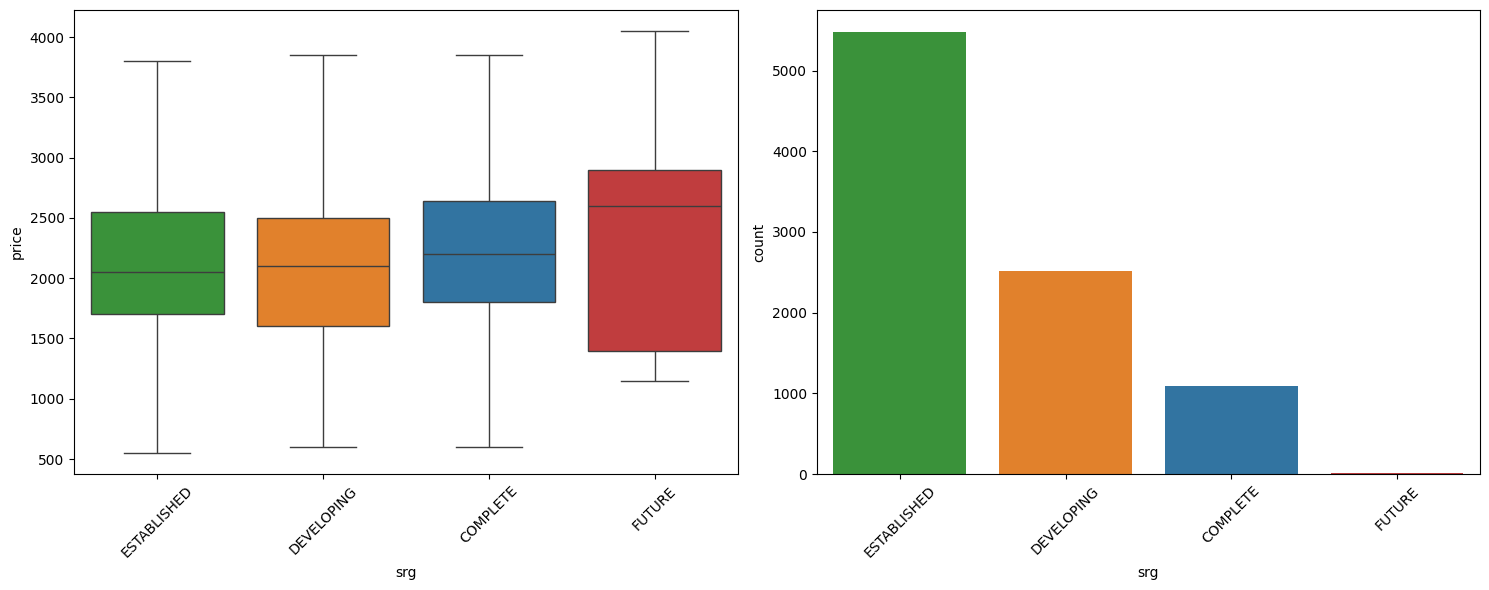

In [151]:
# Determine the order for plotting based on the 'type' value counts
order = rental_listing_crime['srg'].value_counts().sort_values(ascending=False).index

# Create a figure and two axes for subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Boxplot on the left (axs[0])
sns.boxplot(x='srg',
            y='price',
            data=rental_listing_crime,
            showfliers=False,
            hue='srg',
            legend=False,
            ax=axs[0],
            order=order)  # Order the boxplot
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Countplot on the right (axs[1])
sns.countplot(x='srg',
              data=rental_listing_crime,
              hue='srg',
              legend=False,
              ax=axs[1],
              order=order)  # Order the countplot
axs[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

SRG: Reflects the yearly development capacity or housing supply as outlined in the Suburban Residential Growth document

### Insights on Rental Prices by Suburban Residential Growth (SRG) Classification

- **ESTABLISHED** regions, with the highest average rent of $2,228.50, could be benefiting from complete community infrastructure and amenities.
- **COMPLETE** areas show a competitive average rent of $2,207.91, indicating a possibly high demand for areas that are fully developed and no longer expanding.
- Rental prices in **DEVELOPING** areas average at $2,115.09, which might reflect the varying stages of development and the associated appeal to different renters.
- Although data is sparse for **FUTURE** areas (7 entries), the average rent is notably high at $2,327.86, possibly due to expectations of new developments or premium pricing on new constructions.
- The maximum rent in **ESTABLISHED** areas is $14,995, hinting at the presence of high-end housing options within mature neighborhoods.
- Anomalously low minimum rents in **COMPLETE**, **DEVELOPING**, and **ESTABLISHED** communities suggest data inaccuracies that require correction.
- The **DEVELOPING** category's higher standard deviation in rent ($715.53) implies a diverse mix of housing from entry-level to upscale options, in line with transitional neighborhoods.

In [155]:
rental_listing_crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 9106 entries, 0 to 11105
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               9106 non-null   int64         
 1   community        9106 non-null   category      
 2   latitude         9106 non-null   float64       
 3   longitude        9106 non-null   float64       
 4   type             9106 non-null   category      
 5   price            9106 non-null   int64         
 6   beds             9106 non-null   float64       
 7   has_den          9106 non-null   bool          
 8   sq_feet          9106 non-null   float64       
 9   baths            9106 non-null   float64       
 10  cats             9106 non-null   bool          
 11  dogs             9106 non-null   bool          
 12  activation_date  9106 non-null   datetime64[ns]
 13  last_update      9106 non-null   datetime64[ns]
 14  is_active        9106 non-null   boo

Since I am looking for 2-bed condo, visualize the price across different communities:

In [223]:
target_listings_type = rental_listing_crime[(rental_listing_crime['type'] == 'Condo Unit') & (rental_listing_crime['beds'] == 2)]


In [232]:
stats_by_community = target_listings_type.groupby('name').agg(
    count=('name', 'count'),
    average_price=('price', 'mean')
).reset_index()

In [225]:
from shapely.wkt import loads

# Ensuring 'multipolygon' contains WKT strings
rental_listing_crime['geometry'] = rental_listing_crime['multipolygon'].apply(loads)

In [235]:
geo_df = rental_listing_crime[['name', 'geometry']].drop_duplicates().merge(stats_by_community, on='name', how='inner') #using 'inner' to avoid plotting unmatched communities
geo_df.set_geometry('geometry', inplace=True)

In [237]:
geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           132 non-null    object  
 1   geometry       132 non-null    geometry
 2   count          132 non-null    int64   
 3   average_price  132 non-null    float64 
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 4.2+ KB


In [244]:
# Create a base map
m = folium.Map(location=[51, -114], tiles="Cartodb Positron", zoom_start=10)

# Create a Choropleth layer
choropleth = folium.Choropleth(
    geo_data=geo_df,
    data=geo_df,
    columns=['name', 'average_price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # Yellow-Orange-Red color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Price'
).add_to(m)

# Add tooltips
tooltip = GeoJsonTooltip(
    fields=['name', 'average_price','count'],
    aliases=['Community:', 'Average Price:','Count:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

choropleth.geojson.add_child(tooltip)

# Display the map
m